# Who feeds the world ? And how wealthy are they ?
There are **folium maps** in this notebook. If they do not display well, please **have a look at the `.html` file** from the same repository.

## Abstract <a name="abstract"></a>

Our main goal in this project is to find social and economic world-wide relations of countries based on the state of their agricultural sector, using indicators such as imports, exports, production, self-sufficiency, etc. In order to find such indicators, we would like to use the data from the "Global Food & Agriculture Statistics" datasets. First, we would like to produce a map showing which countries "feed the world" i.e. which countries are net-exporting food. That map would contain a slider to show how this evolved over the past fifty years. Then we would like to show countrywise the level of food self-sufficiency i.e. the way a country does not need to trade with other ones in order to feed its population. We will also compare it to nations' economic development and see if some correlations can be found. We will visualize our best findings with several interactive maps and plots.

## Research questions <a name="abstract2"></a>

We would like to work on the following research questions:

- How does the production and consumption of food look like from a geographical point of view ? Which countries are net food exporters or importers? How did this evolve over the last few decades ?
- What's the level of self-sufficiency in food production of individual countries and how does this change over time ?
- Is there a link between the GDP per capita and the agricultural trade balance ? Are countries that are net exporters or importers richer ? Are self-sufficient countries richer ?
- If we find any relations, are they also still valid if we check for specific crops ? Are there some crops that are mostly produced by richer countries, some that are mostly produced by poorer countries?


# Table of contents <a name="toc"></a>


[Abstract](#abstract)

[Research questions](#abstract2) 

[Table of contents](#toc)

1. [Data cleansing and preprocessing](#1)

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
        
    5. [Preprocessing the data set](#1E)
        
    6. [Making one uniformized dataframe](#1F)
        
2. [Data exploration and first observations](#2)
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Consumer price indices](#2B)  
                
    3. [Structure of international trade and historical context](#2C)      
        
    4. [Economic classification of countries](#2D)    
        
3. [Descriptive data analysis](#3)

    1. [Production and consumption of food from a time-space geography point of view](#3A)

    2. [Food self-sufficiency](#3B)

    3. [Giving countries an economic score based on their agricultural features](#3C)

    4. [Food prices stability and agricultural features](#3D)      

4. [Informed plan for next actions](#4)

**External imports:**

In [87]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import json
import re
import requests
from bs4 import BeautifulSoup
from ipywidgets import interact
from IPython.display import display
import scipy.cluster.hierarchy as spc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from operator import itemgetter
from sklearn import preprocessing
from tqdm import tqdm

**Auxiliary function imports:**

We have implemented some functions into a dedicated module (file `Milestone_2_scripts.py`) in order to simplify the code and make this notebook more enjoyable to read.

In [2]:
#from Milestone_2_scripts import *

**Setup:**

In [3]:
data_folder_path = "./Data/current_FAO/raw_files/"

files = {"Crops production" : "Production_Crops_E_All_Data_(Normalized).csv",
         "Food trade" : "Trade_Crops_Livestock_E_All_Data_(Normalized).csv", 
         "Consumer price indices" : "ConsumerPriceIndices_E_All_Data_(Normalized).csv",
         "Macroeconomy" : "Macro-Statistics_Key_Indicators_E_All_Data_(Normalized).csv",
         "Livestock production" : "Production_Livestock_E_All_Data_(Normalized).csv",
         "Live animals trade" : "Trade_LiveAnimals_E_All_Data_(Normalized).csv"
        }
interesting_datasets = files.keys()

## 1. Data cleansing and preprocessing <a name="1"></a>

In this part, we will load, explore and clean the dataset in order to remove typing errors, missing information, inaccuracies, and so on.

1. 

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
    
        1. [Removing unusefull data](#1Da)         
    
            1. [Extracting GDP from the "Macroeconomy" dataset](#1Dai)
            
            2. [Extracting crops harvested area, production, seed and yield from the "Crops production" dataset](#1Daii)
            
            3. [Extracting stocks production from the "Livestock production" dataset](#1Daiii)
            
            4. [Extracting import and export quantities from the "Live animals trade" and "Crops trade" datasets](#1Daiv)
            5. [Extracting average CPI of each year from the "Consumer price indices" dataset](#1Dav)
            
            6. [Removing areas which are not countries](#1Davi)
        
        2. [Handling of the missing data](#1Db)
        
            1. [Highlighting the problem](#1Dbi)
            
            2. [Proposed correction](#1Dbii)        
        
    5. [Preprocessing the data set](#1E)
    
        1. [Converting country names between different naming conventions](#1Ea)
        
        2. [Normalization and log scales](#1Eb)
        
    6. [Making one uniformized dataframe](#1F)

### 1.A. Dataset description <a name="1A"></a>

Our main dataset would be a subset of the "Global Food & Agriculture Statistics" that is found in the proposed datasets list. In this dataset, we have seen that we could work with the production as well as import and export quantities per year and per country. We will add information about countries GDP to this database.

### 1.B. Loading the data set  <a name="1B"></a>

In [4]:
def load_datasets(datasets) :
    df = {}
    for dataset in datasets :
        file_path = data_folder_path + files[dataset]
        df[dataset] = pd.read_csv(file_path, encoding = "ISO-8859-1")
    return df

We load each interresting dataset in the dictionary `df` :

In [5]:
df = load_datasets(interesting_datasets)

### 1.C. Understanding the data set  <a name="1C"></a>

In this part, we will have a first look of the datasets in order to get a first sense of the data.

In [6]:
def display_df(df, datasets):
    for dataset in datasets :
        display(dataset, df[dataset].sample(5))

In order to see what does the datasets look like, we display a sample of 5 rows for each of them :

In [7]:
display_df(df, interesting_datasets)

'Crops production'

Area Code                Area  Item Code            Item  \
2188692       5302        Eastern Asia        515          Apples   
2049606       5200            Americas        210          Lupins   
667545          79             Germany        270        Rapeseed   
2236325       5304  South-Eastern Asia        572        Avocados   
2251619       5304  South-Eastern Asia        267  Sunflower seed   

         Element Code     Element  Year Code  Year    Unit     Value Flag  
2188692          5419       Yield       2014  2014   hg/ha  178154.0   Fc  
2049606          5525        Seed       2012  2012  tonnes    2885.0    A  
667545           5525        Seed       1965  1965  tonnes    5513.0    F  
2236325          5510  Production       1995  1995  tonnes  205979.0    A  
2251619          5525        Seed       1973  1973  tonnes     101.0    A

'Crops trade'

Area Code                Area  Item Code                       Item  \
13749310       5500             Oceania        469     Vegetables, dehydrated   
9205353         200           Singapore        920  Hides, cattle, wet salted   
8029208         170                Peru        653                Food wastes   
5700665         114               Kenya       1075         Offals, liver duck   
3311307          56  Dominican Republic        562               Juice, grape   

          Element Code          Element  Year Code  Year      Unit    Value  \
13749310          5610  Import Quantity       2013  2013    tonnes  14185.0   
9205353           5610  Import Quantity       1997  1997    tonnes      0.0   
8029208           5922     Export Value       1962  1962  1000 US$      0.0   
5700665           5610  Import Quantity       1999  1999    tonnes      NaN   
3311307           5922     Export Value       1994  1994  1000 US$      NaN   

         Flag  
13749310    A  
9205353     *  
8029208   NaN  
5700665     M  
3311307     M

'Consumer price indices'

Area Code                            Area  Item Code  \
31599        256                      Luxembourg      23013   
26227        106                           Italy      23013   
39755        299  Occupied Palestinian Territory      23013   
49372        199                        Slovakia      23012   
42149        171                     Philippines      23012   

                                                Item  Months Code   Months  \
31599     Consumer Prices, Food Indices (2010 = 100)         7005      May   
26227     Consumer Prices, Food Indices (2010 = 100)         7005      May   
39755     Consumer Prices, Food Indices (2010 = 100)         7003    March   
49372  Consumer Prices, General Indices (2010 = 100)         7003    March   
42149  Consumer Prices, General Indices (2010 = 100)         7001  January   

       Year Code  Year  Unit       Value Flag  Note  
31599       2006  2006   NaN   80.850000    X  2015  
26227       2017  2017   NaN  102.300000    X  2015  
39755       2014  2014   NaN  106.790423    X  2010  
49372       2012  2012   NaN  107.101281    X  2010  
42149       2004  2004   NaN   71.618257    X  2010

'Macroeconomy'

Area Code          Area  Item Code  \
127276        279       Curaçao      22077   
233431        106         Italy      22015   
524864        248  Yugoslav SFR      22016   
165059        238      Ethiopia      22078   
182925         73       Georgia      22016   

                                                   Item  Element Code  \
127276  Value Added (Manufacture of food and beverages)          6110   
233431                    Gross Fixed Capital Formation          6129   
524864  Value Added (Agriculture, Forestry and Fishing)          6110   
165059    Value Added (Manufacture of tobacco products)          6114   
182925  Value Added (Agriculture, Forestry and Fishing)          6114   

                                  Element  Year Code  Year      Unit  \
127276                          Value US$       1984  1984  millions   
233431                  Annual growth US$       1991  1991         %   
524864                          Value US$       1993  1993  millions   
165059  Value Local Currency, 2005 prices       2009  2009  millions   
182925  Value Local Currency, 2005 prices       1983  1983  millions   

             Value Flag  
127276         NaN  NaN  
233431    3.535503   Fc  
524864         NaN  XAM  
165059  298.231675   Fc  
182925         NaN  XAM

'Livestock production'

Area Code                              Area  Item Code      Item  \
77592        143                           Morocco       1034      Pigs   
28546         47                      Cook Islands       1181  Beehives   
51617        175                     Guinea-Bissau       1057  Chickens   
55909        100                             India       1068     Ducks   
13149         19  Bolivia (Plurinational State of)       1110     Mules   

       Element Code Element  Year Code  Year       Unit    Value Flag  
77592          5111  Stocks       1996  1996       Head   9500.0    F  
28546          5114  Stocks       1966  1966         No     10.0    F  
51617          5112  Stocks       2005  2005  1000 Head   1099.0  NaN  
55909          5112  Stocks       1996  1996  1000 Head  29300.0    F  
13149          5111  Stocks       2006  2006       Head  82000.0    F

'Live animals trade'

Area Code                            Area  Item Code  \
96949         351                           China       1107   
651261       5803  Small Island Developing States        866   
13181           9                       Argentina       1107   
173562         68                          France       1126   
258173        118                          Kuwait         10   

                           Item  Element Code          Element  Year Code  \
96949                     Asses          5908  Export Quantity       1974   
651261                   Cattle          5622     Import Value       1977   
13181                     Asses          5922     Export Value       1998   
173562                   Camels          5922     Export Value       1987   
258173  Total Merchandise Trade          5622     Import Value       1980   

        Year      Unit      Value Flag  
96949   1974      Head        0.0    A  
651261  1977  1000 US$     6287.0    A  
13181   1998  1000 US$        0.0    F  
173562  1987  1000 US$        NaN    M  
258173  1980  1000 US$  6543608.0  NaN

At first glance, our datasets seem very clean.

Each of our dataset contains a column "Year" and a column that is either named "Area" or "Country". This is a great news for us since we want to do a both geographical and time-related analysis.

The columns "Area" and "Country" both correspond to the country except that the "Area" may contains a group of country (e.g. "Eastern Europe").

### 1.D. Cleansing the data set  <a name="1D"></a>

In this part, we will clean the datasets. The final goal is to produce one uniformized and normalized dataset on which we could work (see [1.F](#1F)).

Such a cleaned dataset may look like this  (in a very simplistic way):

    Country | Year | GDP | Crops production | Livestock production

#### 1.D.a. Removing unuseful data  <a name="1Da"></a>

In this section, we will create dataframes in `df_useful` which correspond to previous dataframes without the unuseful data.

In [8]:
df_useful = {}

##### 1.D.a.i. Extracting GDP from the "Macroeconomy" dataset <a name="1Dai"></a>
The "Macroeconomy" dataset contains many different measures: Gross Fixed Capital Formation, Gross National Income, Value Added (Total Manufacturing), ... We are only interested in Gross Domestic Product. Therefore, we extract it Gross Domestic Product from the "Macroeconomy" dataset. In order to have uniformisation among values, we choose the US$ value. All of them have the same unit (millions US$) so we can drop the "Unit" column as well.

In [9]:
def extract_GDP(df):
    def selection_GDP(df):
        return df['Item']=='Gross Domestic Product'
    def selection_US_dollars(df):
        return df['Element']=="Value US$"
    def drop_columns(df):
        dropped_colmuns = ["Item Code", "Item", "Element Code", "Element", "Flag", "Year Code", "Unit"]
        return df.drop(columns = dropped_colmuns)
    return drop_columns(df[selection_GDP(df)&selection_US_dollars(df)])

In [10]:
df_useful["GDP"] = extract_GDP(df["Macroeconomy"])

We can have have a look at a sample of the extrated dataset:

In [11]:
display(df_useful["GDP"].sample(5))

Area Code        Area  Year          Value
177196         74       Gabon  2015   13734.558945
315383        143     Morocco  1970    4644.867410
29930          52  Azerbaijan  1999    4581.222443
557760       5500     Oceania  1999  502921.272019
126143        279     Curaçao  1993            NaN

And we can plot GDP in million US$ for different countries for the period 1970-2015:

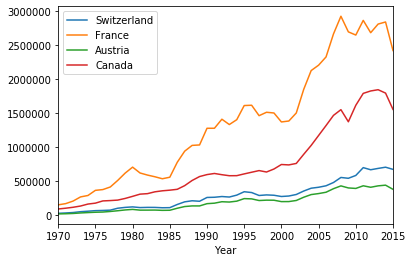

In [12]:
select_switzerland = df_useful["GDP"]['Area']=='Switzerland'
select_france = df_useful["GDP"]['Area']=='France'
select_austria = df_useful["GDP"]['Area']=='Austria'
select_canada = df_useful["GDP"]['Area']=='Canada'
ax = df_useful["GDP"][select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["GDP"][select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

For dissolute or new countries, we have some Nan values (before appearing or after dissolution) as in this next example :

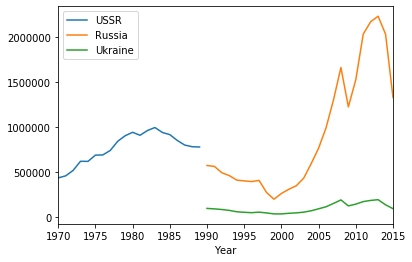

In [13]:
select_USSR = df_useful["GDP"]['Area']=='USSR'
select_russia = df_useful["GDP"]['Area']=='Russian Federation'
select_ukraine = df_useful["GDP"]['Area']=='Ukraine'
ax = df_useful["GDP"][select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["GDP"][select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

##### 1.D.a.ii. Extracting crops harvested area, production, seed and yield from the "Crops production" dataset<a name="1Daii"></a>
We want to extract crops harvested area, production, seed and yield from the "Crops production" dataset. As all crops are not food crops, we request the [World crops database](https://world-crops.com/food-crops/) to keep only the food crops.

In [14]:
def get_food_crops():
    #Return a list of crops categorized as food crops https://world-crops.com/food-crops/
    url="https://world-crops.com/food-crops/"
    r=requests.get(url,headers={"User-Agent": "XY"})
    soup=BeautifulSoup(r.text,'html.parser')
    elements_temp=soup.find_all('a',href=re.compile("^../"))
    elements=[el.text for el in elements_temp]
    
    #only 40 elements are displayed on each page->iterating on the total list
    for i in range(40,401,40):
        url_i=url+"?ss="+str(i)
        r=requests.get(url_i,headers={"User-Agent":"XY"})
        soup=BeautifulSoup(r.text,'html.parser')
        new_elements=soup.find_all('a',href=re.compile("^../"))
        elements+=[el.text for el in new_elements]
    return elements

def inclusive_search(string,elements):
    #returns true if the string can be found in elements. The search removes special characters from string in order to include more positive results
    string=string.lower()
    delimiters = ",", "(","&",")"," and "," "
    pattern = '|'.join(map(re.escape, delimiters))
    strings=list(filter(None,re.split(pattern,string)))
    found=False
    for s in strings:
        if s=="nes":
            continue
        for el in elements:
            found=(s in el.split())
            if found==False and s[-1]=="s":
                found=s[:-1] in el.split()
            if found==False and s[-2:]=="es":
                found=s[:-2] in el.split()
            if found==False and s[-3:]=="ies":
                found=s[:-3]+"y" in el.split()
            if found==True:
                return found
    return found


def get_food_crop_data(df):    
    #extracts the food crop data, returns 4 df: Area,Production,Seed and yield    
    df=df.copy()
    food_crops=list(map(lambda x: x.lower(),get_food_crops()))              
    crop_types_df=df[['Item','Value']].groupby('Item').sum()
    crop_types_df=crop_types_df[list(map(lambda x : inclusive_search(x,food_crops) , crop_types_df.index ))]   
    food_crop_df=df[df.Item.apply(lambda x: x in crop_types_df.index)]
    return (food_crop_df[food_crop_df.Element=='Area harvested'],
            food_crop_df[food_crop_df.Element=='Production'],
            food_crop_df[food_crop_df.Element=='Seed'],
            food_crop_df[food_crop_df.Element=='Yield'])
  
food_crop_area_df , food_crop_production_df , food_crop_seed_df , food_crop_yield_df = get_food_crop_data(df["Crops production"])

In [15]:
df_useful['Crops Area harvested'] = food_crop_area_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Crops Production'] = food_crop_production_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Crops Seed'] = food_crop_seed_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Crops Yield'] =  food_crop_yield_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

We check everything is fine by looking at samples for each of the new dataframes:

In [16]:
display(df_useful['Crops Area harvested'].sample(5))
display(df_useful['Crops Production'].sample(5))
display(df_useful['Crops Seed'].sample(5))
display(df_useful['Crops Yield'].sample(5))

Area Code                                     Area  \
925785         112                                   Jordan   
701310          86                                  Grenada   
149223          23                                   Belize   
1691842        222                                  Tunisia   
2572774       5817  Net Food Importing Developing Countries   

                           Item  Year Unit     Value  
925785                  Quinces  2011   ha       NaN  
701310                 Coconuts  1999   ha    1948.0  
149223   Groundnuts, with shell  1977   ha       NaN  
1691842  Eggplants (aubergines)  1991   ha      14.0  
2572774         Castor oil seed  1998   ha  131122.0

Area Code                Area               Item  Year    Unit  \
1926603       5100              Africa             Lupins  1978  tonnes   
529039          56  Dominican Republic             Garlic  2010  tonnes   
588642         238            Ethiopia  Fruit, citrus nes  2009  tonnes   
1235692        159             Nigeria            Papayas  2001  tonnes   
1846884        249               Yemen            Lentils  2014  tonnes   

            Value  
1926603    7330.0  
529039     2001.0  
588642     3151.0  
1235692  745416.0  
1846884    9049.0

Area Code          Area                    Item  Year    Unit  \
1733918        226        Uganda  Roots and Tubers,Total  1978  tonnes   
595842          62  Ethiopia PDR                   Maize  1973  tonnes   
2180886       5301  Central Asia              Beans, dry  2002  tonnes   
1090137        137     Mauritius  Groundnuts, with shell  1963  tonnes   
1874202        181      Zimbabwe                  Millet  1992  tonnes   

           Value  
1733918  16800.0  
595842   22050.0  
2180886    790.0  
1090137     13.0  
1874202   3830.0

Area Code                   Area                      Item  Year  \
1173053        148                  Nauru  Vegetables&Melons, Total  1986   
786459          97                Hungary     Roots and tubers, nes  1965   
416789          47           Cook Islands          Fruit, fresh nes  2007   
1490074        186  Serbia and Montenegro               Watermelons  1993   
1800291        228                   USSR    Cucumbers and gherkins  1973   

          Unit     Value  
1173053  hg/ha   74000.0  
786459   hg/ha  100000.0  
416789   hg/ha   16195.0  
1490074  hg/ha   93082.0  
1800291  hg/ha   74882.0

We also make some plots to have a first understanding of the dataset:

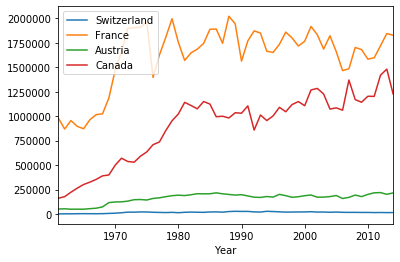

In [17]:
select_Maize = df_useful['Crops Area harvested']['Item']=='Maize'
maize_df = df_useful['Crops Area harvested'][select_Maize]

select_switzerland = maize_df['Area']=='Switzerland'
select_france = maize_df['Area']=='France'
select_austria = maize_df['Area']=='Austria'
select_canada = maize_df['Area']=='Canada'
ax = maize_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

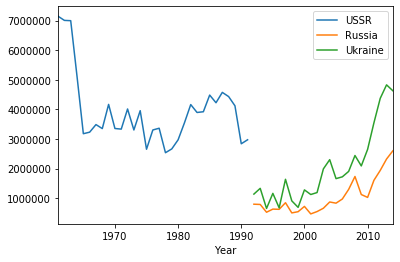

In [18]:
select_USSR = maize_df['Area']=='USSR'
select_russia = maize_df['Area']=='Russian Federation'
select_ukraine = maize_df['Area']=='Ukraine'
ax = maize_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

##### 1.D.a.iii. Extracting stocks production from the "Livestock production" dataset<a name="1Daiii"></a>

We want to extract stocks production from the "Livestock production" dataset. Again, we drop the columns that are useless for us and have a first look of the data with a sample and some plots.

In [19]:
selection_stocks = df['Livestock production']["Element"] == 'Stocks'
df_useful['Livestock production'] = df['Livestock production'][selection_stocks].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [20]:
display(df_useful['Livestock production'].sample(5))

Area Code                                          Area  \
56808         101                                     Indonesia   
1315            3                                       Albania   
98684         187  Saint Helena, Ascension and Tristan da Cunha   
110706        210                                        Sweden   
67596         123                                       Liberia   

                        Item  Year  Unit      Value  
56808   Cattle and Buffaloes  1977  Head  8509000.0  
1315    Cattle and Buffaloes  1980  Head   607700.0  
98684        Sheep and Goats  2000  Head     1859.0  
110706                Horses  1988  Head    57500.0  
67596   Cattle and Buffaloes  1989  Head    40000.0

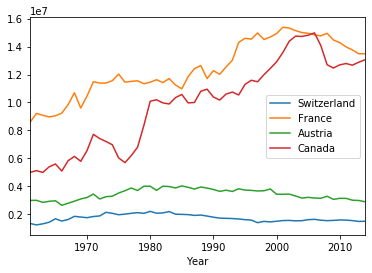

In [21]:
select_pigs = df_useful['Livestock production']['Item']=='Pigs'
pigs_df = df_useful['Livestock production'][select_pigs]

select_switzerland = pigs_df['Area']=='Switzerland'
select_france = pigs_df['Area']=='France'
select_austria = pigs_df['Area']=='Austria'
select_canada = pigs_df['Area']=='Canada'
ax = pigs_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

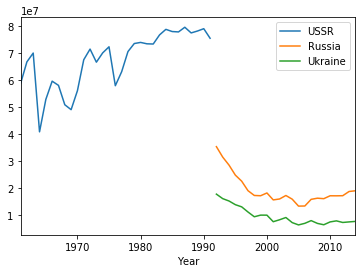

In [22]:
select_USSR = pigs_df['Area']=='USSR'
select_russia = pigs_df['Area']=='Russian Federation'
select_ukraine = pigs_df['Area']=='Ukraine'
ax = pigs_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

##### 1.D.a.iv. Extracting import and export quantities from the "Live animals trade" and "Crops trade" datasets<a name="1Daiv"></a>
Now, we extract import and export quantities from the "Live animals trade" and "Crops trade" datasets, having again some samples and some plots.

In [23]:
selection_import_quantities = df['Live animals trade']["Element"] == 'Import Quantity'
selection_export_quantities = df['Live animals trade']["Element"] == 'Export Quantity'

df_useful['Live animals import quantities'] = df['Live animals trade'][selection_import_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Live animals export quantities'] = df['Live animals trade'][selection_export_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [24]:
display(df_useful['Live animals import quantities'].sample(5))

Area Code              Area             Item  Year       Unit  \
210318         95          Honduras           Horses  1961       Head   
484229        229    United Kingdom            Mules  1977       Head   
262923        119            Latvia  Bovine, Animals  2009       Head   
607596       5401    Eastern Europe            Sheep  1978       Head   
103878        128  China, Macao SAR            Ducks  2013  1000 Head   

           Value  
210318      40.0  
484229       5.0  
262923     661.0  
607596  657479.0  
103878       NaN

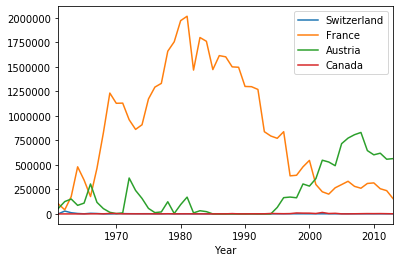

In [25]:
select_pigs = df_useful['Live animals import quantities']['Item']=='Pigs'
pigs_df = df_useful['Live animals import quantities'][select_pigs]

select_switzerland = pigs_df['Area']=='Switzerland'
select_france = pigs_df['Area']=='France'
select_austria = pigs_df['Area']=='Austria'
select_canada = pigs_df['Area']=='Canada'
ax = pigs_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

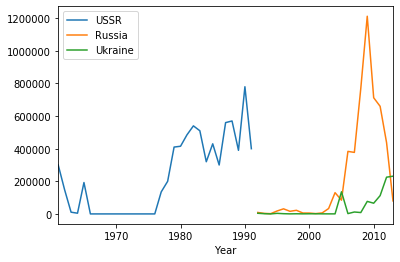

In [26]:
select_USSR = pigs_df['Area']=='USSR'
select_russia = pigs_df['Area']=='Russian Federation'
select_ukraine = pigs_df['Area']=='Ukraine'
ax = pigs_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

In [27]:
display(df_useful['Live animals export quantities'].sample(5))

Area Code                  Area                  Item  Year  Unit  \
601231       5400                Europe       Camelids, other  1979  Head   
541059       5102         Middle Africa                  Pigs  1983  Head   
338689        162                Norway       Camelids, other  1972  Head   
519892        268          EU(25)ex.int  Pigeons, other birds  2009  Head   
479695        225  United Arab Emirates                Cattle  2001  Head   

        Value  
601231    NaN  
541059    0.0  
338689    NaN  
519892  113.0  
479695    0.0

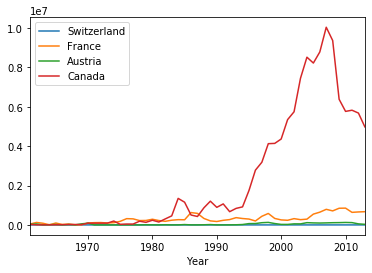

In [28]:
select_pigs = df_useful['Live animals export quantities']['Item']=='Pigs'
pigs_df = df_useful['Live animals export quantities'][select_pigs]

select_switzerland = pigs_df['Area']=='Switzerland'
select_france = pigs_df['Area']=='France'
select_austria = pigs_df['Area']=='Austria'
select_canada = pigs_df['Area']=='Canada'
ax = pigs_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

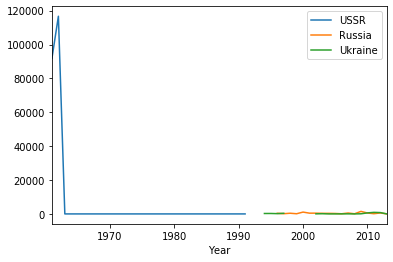

In [29]:
select_USSR = pigs_df['Area']=='USSR'
select_russia = pigs_df['Area']=='Russian Federation'
select_ukraine = pigs_df['Area']=='Ukraine'
ax = pigs_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = pigs_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = pigs_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

In [30]:
selection_import_quantities = df['Food trade']["Element"] == 'Import Quantity'
selection_export_quantities = df['Food trade']["Element"] == 'Export Quantity'

df_useful['Food import quantities'] = df['Food trade'][selection_import_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Food export quantities'] = df['Food trade'][selection_export_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [31]:
display(df_useful['Food import quantities'].sample(5))

Area Code                  Area                  Item  Year    Unit  \
2273195         96  China, Hong Kong SAR    Coffee Green+Roast  1969  tonnes   
3023669        167               Czechia                 Dates  2008  tonnes   
582006          11               Austria            Total Meat  2003  tonnes   
8163047        173                Poland           Bran, wheat  1976  tonnes   
8977280        194          Saudi Arabia  Tobacco products nes  1993  tonnes   

            Value  
2273195   45155.0  
3023669     600.0  
582006   178748.0  
8163047       NaN  
8977280    8129.0

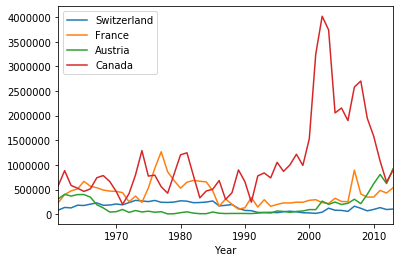

In [32]:
select_Maize = df_useful['Food import quantities']['Item']=='Maize'
maize_df = df_useful['Food import quantities'][select_Maize]

select_switzerland = maize_df['Area']=='Switzerland'
select_france = maize_df['Area']=='France'
select_austria = maize_df['Area']=='Austria'
select_canada = maize_df['Area']=='Canada'
ax = maize_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

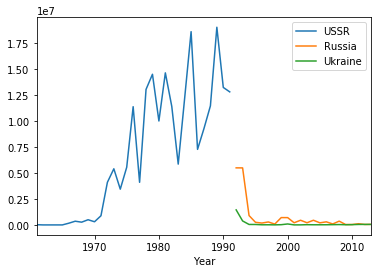

In [33]:
select_USSR = maize_df['Area']=='USSR'
select_russia = maize_df['Area']=='Russian Federation'
select_ukraine = maize_df['Area']=='Ukraine'
ax = maize_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

In [34]:
display(df_useful['Food export quantities'].sample(5))

Area Code                              Area  \
3446958          59                             Egypt   
14227830       5802  Land Locked Developing Countries   
493349           10                         Australia   
7490598         159                           Nigeria   
3026740         167                           Czechia   

                                    Item  Year    Unit  Value  
3446958   Juice, pineapple, concentrated  1965  tonnes    NaN  
14227830                    Cotton waste  1970  tonnes  556.0  
493349                          Oilseeds  1962  tonnes    0.0  
7490598                   Flax fibre raw  1980  tonnes    NaN  
3026740                 Fruit, fresh nes  2013  tonnes  404.0

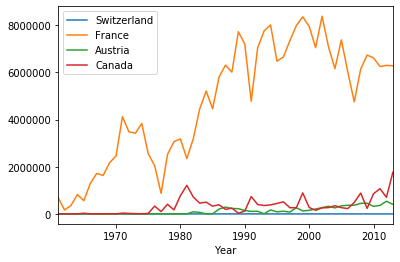

In [35]:
select_Maize = df_useful['Food export quantities']['Item']=='Maize'
maize_df = df_useful['Food export quantities'][select_Maize]

select_switzerland = maize_df['Area']=='Switzerland'
select_france = maize_df['Area']=='France'
select_austria = maize_df['Area']=='Austria'
select_canada = maize_df['Area']=='Canada'
ax = maize_df[select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

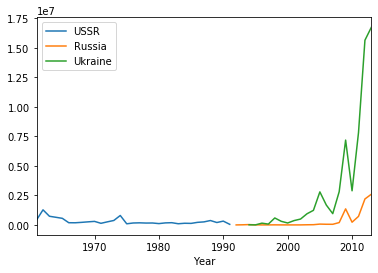

In [36]:
select_USSR = maize_df['Area']=='USSR'
select_russia = maize_df['Area']=='Russian Federation'
select_ukraine = maize_df['Area']=='Ukraine'
ax = maize_df[select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = maize_df[select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = maize_df[select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

##### 1.D.a.v. Extracting average CPI of each year from the "Consumer price indices" dataset<a name="1Dav"></a>

The "Consumer price indices" dataset contains monthly data. In order to have a uniform dataframe, and as other dataframes have yearly data, we group it by (Country, Year) and compute the mean over the monthes.

In [37]:
df_useful['Consumer price indices'] =  df['Consumer price indices'][['Area',"Year",'Value']] \
                                        .dropna() \
                                        .groupby(['Area',"Year"]) \
                                        .mean() \
                                        .reset_index() \
                                        .dropna()

With samples and plots, we remark that this dataset only start in 2000 wheareas other ones start in 1970.

In [38]:
display(df_useful['Consumer price indices'].sample(5))

Area  Year       Value
533    Cambodia  2013  142.662578
2479    Romania  2000   31.984321
2049    Myanmar  2012  106.562737
1378    Iceland  2001   58.249827
160   Australia  2014  104.407549

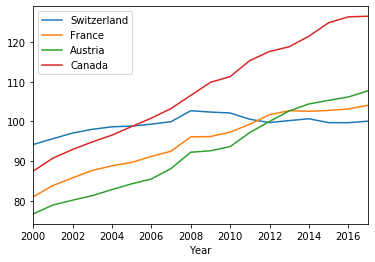

In [39]:
select_switzerland = df_useful['Consumer price indices']['Area']=='Switzerland'
select_france = df_useful['Consumer price indices']['Area']=='France'
select_austria = df_useful['Consumer price indices']['Area']=='Austria'
select_canada = df_useful['Consumer price indices']['Area']=='Canada'
ax = df_useful['Consumer price indices'][select_switzerland].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful['Consumer price indices'][select_france].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful['Consumer price indices'][select_austria].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful['Consumer price indices'][select_canada].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["Switzerland", 'France', 'Austria', "Canada"])

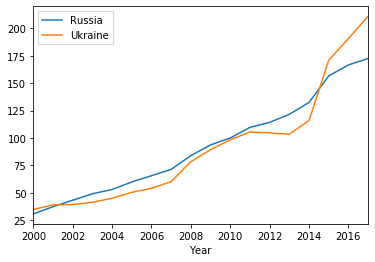

In [40]:
select_russia = df_useful["Consumer price indices"]['Area']=='Russian Federation'
select_ukraine = df_useful["Consumer price indices"]['Area']=='Ukraine'
ax = df_useful["Consumer price indices"][select_russia].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["Consumer price indices"][select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(['Russia', 'Ukraine'])

##### 1.D.a.vi. Removing areas which are not countries <a name="1Davi"></a>

Having a more detailled look at the dataset, we have remarked that the areas which are real countries are exactely the ones with an "Area Code" below $5000$ but not in $[261, 269]$.

In [41]:
#remove Area code >= 5000 or in [261, 269] (EU)
for df_name in df_useful :
    if 'Area Code' in df_useful[df_name].keys() : 
        print ("Removing areas which are not countries in", df_name)
        selection_countries = df_useful[df_name]['Area Code']<261 
        selection_countries = selection_countries | df_useful[df_name]['Area Code']>269
        selection_countries = selection_countries & df_useful[df_name]['Area Code']<5000
        df_useful[df_name] = df_useful[df_name][selection_countries]
        display(df_useful[df_name].sample(5))
    else :
        print (df_name, "is already clean")

Removing areas which are not countries in GDP


Area Code                              Area  Year         Value
182200         73                           Georgia  1976           NaN
256417        120  Lao People's Democratic Republic  1995   1708.075312
350863        299    Occupied Palestinian Territory  2011  10465.400000
54176          18                            Bhutan  1995    289.135174
293496        127                  Marshall Islands  2008    152.793449

Removing areas which are not countries in Crops Area harvested


Area Code                        Area  \
794041         100                       India   
719493          89                   Guatemala   
828023         102  Iran (Islamic Republic of)   
1173663        149                       Nepal   
171657          18                      Bhutan   

                                     Item  Year Unit     Value  
794041                         Areca nuts  1997   ha  261200.0  
719493   Anise, badian, fennel, coriander  1981   ha       NaN  
828023          Fruit, tropical fresh nes  1982   ha       4.0  
1173663                           Bananas  1964   ha       NaN  
171657        Pumpkins, squash and gourds  1974   ha       NaN

Removing areas which are not countries in Crops Production


Area Code                Area                       Item  Year  \
2023922       5105      Western Africa     Eggplants (aubergines)  1961   
596167          62        Ethiopia PDR                  Nuts, nes  1968   
2189455       5302        Eastern Asia                   Avocados  1975   
994246         122             Lesotho  Cereals (Rice Milled Eqv)  1989   
526872          56  Dominican Republic        Carrots and turnips  1987   

           Unit     Value  
2023922  tonnes   15000.0  
596167   tonnes   23000.0  
2189455  tonnes       0.0  
994246   tonnes  199365.0  
526872   tonnes    8898.0

Removing areas which are not countries in Crops Seed


Area Code                                     Area       Item  Year  \
2580741       5817  Net Food Importing Developing Countries      Maize  1996   
2565126       5815        Low Income Food Deficit Countries       Yams  1971   
1554199        203                                    Spain  Peas, dry  2000   
558535          59                                    Egypt    Lentils  2004   
2557957       5815        Low Income Food Deficit Countries   Potatoes  1972   

           Unit      Value  
2580741  tonnes   579154.0  
2565126  tonnes   654152.0  
1554199  tonnes     5900.0  
558535   tonnes      300.0  
2557957  tonnes  1167665.0

Removing areas which are not countries in Crops Yield


Area Code                              Area  \
616516          68                            France   
620056          68                            France   
96281           11                           Austria   
496900         250  Democratic Republic of the Congo   
2320643       5401                    Eastern Europe   

                              Item  Year   Unit     Value  
616516                      Apples  2000  hg/ha  309455.0  
620056      Eggplants (aubergines)  1989  hg/ha  276647.0  
96281                        Wheat  1962  hg/ha   26122.0  
496900   Grapefruit (inc. pomelos)  1980  hg/ha  150000.0  
2320643                    Vetches  2000  hg/ha   14944.0

Removing areas which are not countries in Livestock production


Area Code             Area           Item  Year       Unit       Value
146487       5305     Western Asia          Sheep  1982       Head  83250563.0
139208       5204  Central America  Poultry Birds  1975  1000 Head    182428.0
31989          50           Cyprus  Poultry Birds  1978  1000 Head      2793.0
58685         104          Ireland          Ducks  1972  1000 Head       150.0
39711         238         Ethiopia          Mules  2009       Head    365584.0

Removing areas which are not countries in Live animals import quantities


Area Code             Area     Item  Year       Unit    Value
519232        266     EU(15)ex.int  Turkeys  2001  1000 Head    825.0
209595         95         Honduras   Cattle  1980       Head  77475.0
545324       5103  Northern Africa     Pigs  2008       Head    340.0
264244        121          Lebanon    Ducks  1975  1000 Head      NaN
183755         79          Germany    Asses  2004       Head      0.0

Removing areas which are not countries in Live animals export quantities


Area Code                              Area               Item  Year  \
647814       5802  Land Locked Developing Countries             Horses  1975   
140602         54                           Denmark           Chickens  2009   
108077         41                   China, mainland  Rabbits and hares  1972   
365873        173                            Poland           Chickens  2001   
556963       5200                          Americas              Goats  1987   

             Unit    Value  
647814       Head  69386.0  
140602  1000 Head  35177.0  
108077  1000 Head      0.0  
365873  1000 Head   1231.0  
556963       Head    311.0

Removing areas which are not countries in Crops import quantities


Area Code                Area                      Item  Year  \
939894           15  Belgium-Luxembourg                  Cherries  1968   
14113368       5706      European Union  Groundnuts Total Shelled  1978   
5007533         101           Indonesia                     Maize  2011   
7674303         221                Oman               Bran, wheat  1987   
11404268        251              Zambia               Meat, horse  2001   

            Unit      Value  
939894    tonnes     2635.0  
14113368  tonnes   512043.0  
5007533   tonnes  3207657.0  
7674303   tonnes        NaN  
11404268  tonnes        0.0

Removing areas which are not countries in Crops export quantities


Area Code            Area                          Item  Year  \
875216           14        Barbados      Sugar,Total (Raw Equiv.)  2004   
12284404       5105  Western Africa                    Kiwi fruit  1974   
9952437         211     Switzerland        Peaches and nectarines  1984   
8574449         183         Romania     Vegetables, preserved nes  1975   
4147728          79         Germany  Feed, vegetable products nes  1972   

            Unit    Value  
875216    tonnes  32904.0  
12284404  tonnes      NaN  
9952437   tonnes      1.0  
8574449   tonnes  40200.0  
4147728   tonnes    926.0

Consumer price indices is already clean


#### 1.D.b. Handling of the missing data  <a name="1Db"></a>

In this section, we will explain how we will handle the missing data in previous dataframes for maps.

##### 1.D.b.i. Highlighting the problem  <a name="1Dbi"></a> 

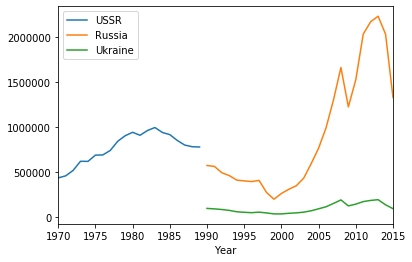

In [42]:
select_USSR = df_useful["GDP"]['Area']=='USSR'
select_russia = df_useful["GDP"]['Area']=='Russian Federation'
select_ukraine = df_useful["GDP"]['Area']=='Ukraine'
ax = df_useful["GDP"][select_USSR].plot(x ='Year', y='Value', kind = 'line')
ax = df_useful["GDP"][select_russia].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax = df_useful["GDP"][select_ukraine].plot(x ='Year', y='Value', kind = 'line', ax = ax)
ax.legend(["USSR", 'Russia', 'Ukraine'])

In order to vizualize folium maps, we need to associate each country a value. The geojson file that we use is not timestamped and only countries that exist nowadays are inside it. As some countries has been dissolved during the past 50 years, our folium maps won't be complete. For instance, we do not have any value for Ukraine from 1970 to 1989. Our idea to fix this issue is presented in the next paragraph.

##### 1.D.b.ii. Proposed correction  <a name="1Dbii"></a> 


Our idea is to map the former country value to each of the current ones. For instance in 1982, USSR GDP is around one trillion $. Therefore, if we associate (only for folium map purposes) this value to each current country that succeeded USSR, all these countries will appear the same color in the folium map, i.e. all the USSR area will appear the same color (and the good one).

In order to do so, one need to identify which countries appeared and disappeared from the dataset and at which year. Then we will use this result along with some historical research in our `visualise_world_data_folium` function ([1Ea](#1Ea)).

In [43]:
countries_formation_years = {}
for country in df_useful["GDP"]["Area"].unique():
    selection = df_useful["GDP"]["Area"] == country
    year_in, year_out = df_useful["GDP"][selection].dropna()["Year"].min(), df_useful["GDP"][selection].dropna()["Year"].max()
    for year in (year_in, year_out):
        if year not in countries_formation_years :
            countries_formation_years[year] = []
    countries_formation_years[year_in].append((country,'+'))
    countries_formation_years[year_out].append((country,'-'))

countries_formation_years.pop(1970)
countries_formation_years.pop(2015)
for year in sorted(list(countries_formation_years)):
    print (year, countries_formation_years[year])

1988 [('Yemen Ar Rp', '-'), ('Yemen Dem', '-')]
1989 [('Czechoslovakia', '-'), ('Ethiopia PDR', '-'), ('USSR', '-'), ('Yemen', '+'), ('Yugoslav SFR', '-')]
1990 [('Armenia', '+'), ('Azerbaijan', '+'), ('Belarus', '+'), ('Bosnia and Herzegovina', '+'), ('Croatia', '+'), ('Czechia', '+'), ('Eritrea', '+'), ('Estonia', '+'), ('Ethiopia', '+'), ('Georgia', '+'), ('Kazakhstan', '+'), ('Kyrgyzstan', '+'), ('Latvia', '+'), ('Lithuania', '+'), ('Montenegro', '+'), ('Republic of Moldova', '+'), ('Russian Federation', '+'), ('Serbia', '+'), ('Slovakia', '+'), ('Slovenia', '+'), ('Tajikistan', '+'), ('The former Yugoslav Republic of Macedonia', '+'), ('Timor-Leste', '+'), ('Turkmenistan', '+'), ('Ukraine', '+'), ('Uzbekistan', '+'), ('Central Asia', '+')]
1999 [('Kosovo', '+')]
2005 [('Curaçao', '+'), ('Sint Maarten (Dutch Part)', '+')]
2007 [('Sudan (former)', '-')]
2008 [('South Sudan', '+'), ('Sudan', '+')]
2012 [('Netherlands Antilles (former)', '-')]


### 1.E. Preprocessing the data set  <a name="1E"></a>

In this part, we will finish prepocessing the datasets. More precisely, we will deal with country names and normalizing the features.

#### 1.E.a. Converting country names between different naming conventions  <a name="1Ea"></a>
Some countries have different names in the geojson file and in the dataset. We first start by correcting them.

In [44]:
dic = {'Czechia': "Czech Republic",
       'Russian Federation':'Russia',
       "Serbia":"Republic of Serbia",
       'The former Yugoslav Republic of Macedonia':'Macedonia',
       'China, mainland':'China',
       'Viet Nam':'Vietnam',
       'Venezuela (Bolivarian Republic of)':'Venezuela',
       'Iran (Islamic Republic of)':'Iran',
       'Syrian Arab Republic':"Syria",
       'Bolivia (Plurinational State of)': 'Bolivia',
       "Côte d'Ivoire": "Ivory Coast",
       'Congo':"Republic of the Congo",
       "Lao People's Democratic Republic":'Laos',
       "Democratic People's Republic of Korea":"North Korea",
       'Republic of Korea':"South Korea"}

def correct_country_names(old_name):
    if old_name in dic.keys() :
        return dic[old_name]
    return old_name


In [45]:
for df_name in df_useful :
    print (df_name)
    df_useful[df_name]["Area"] = df_useful[df_name]["Area"].apply(correct_country_names)

GDP
Crops Area harvested
Crops Production
Crops Seed
Crops Yield
Livestock production
Live animals import quantities
Live animals export quantities
Crops import quantities
Crops export quantities
Consumer price indices


Then, we do a function that takes as input a dataframe and a year and produces the corresponding folium map. This function also handles dissolutions of countries as suggested [before](#1Dbii).

In [46]:
def visualise_world_data_folium(df, year, logScale=True):
    dic = {'USSR':                            ['Armenia', 'Azerbaijan','Belarus', 'Estonia', 'Georgia',
                                               'Kazakhstan', 'Kyrgyzstan', 'Latvia', 'Lithuania',
                                               'Montenegro', 'Republic of Moldova', 'Russia',
                                               'Republic of Serbia', 'Timor-Leste', 'Turkmenistan', 'Ukraine',
                                               'Uzbekistan'],
           'Ethiopia PDR':                     ['Eritrea','Ethiopia'],
           'Yugoslav SFR':                     ['Kosovo', 'Slovenia', 'Croatia',
                                                'Macedonia', 'Bosnia and Herzegovina'],
           'Yemen Dem' :                       ['Yemen'],        
           'Czechoslovakia':                   ["Czech Republic", 'Slovakia'],
           'Netherlands Antilles (former)':    ['Curaçao', 'Sint Maarten (Dutch Part)'],
           'Sudan (former)':                   ['South Sudan', 'Sudan']
          }
    def add_new_names(old_name):
        if old_name in dic.keys() :
            return dic[old_name]
        return old_name
    to_plot=df[df["Year"]==year]
    to_plot=(to_plot[['Area','Value']]
             .dropna()
             .groupby('Area')             
             .mean()
             .reset_index()
             .dropna())    
    to_plot['Area']=to_plot['Area'].apply(add_new_names)
    to_plot = to_plot.explode('Area')
    if logScale :
        to_plot.Value=np.log10(to_plot.Value)
    
    m = folium.Map(location=[40,-10],zoom_start=1.6)
    folium.Choropleth(
        geo_data=f"https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json",
        data=to_plot,
        columns=['Area', 'Value'],
        key_on='feature.properties.name',
        fill_color='YlGn',fill_opacity=0.7,line_opacity=0.2,nan_fill_opacity=0.0
    ).add_to(m)

    folium.LayerControl().add_to(m)

    return(m)

We can know use it to produce some maps. For instance, we plot below the map of GDP for the year 1985 (befor edissolution of USSR).

In [47]:
display(visualise_world_data_folium(df_useful["GDP"], 1985, True))

#### 1.E.b. Normalization and log scales  <a name="1Eb"></a>

Some of our features seem to be right skewed. At first glance it seems that they look like power laws.

For instance the distribution of GDP look a bit like a power law:

C:\Users\nanil\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\nanil\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


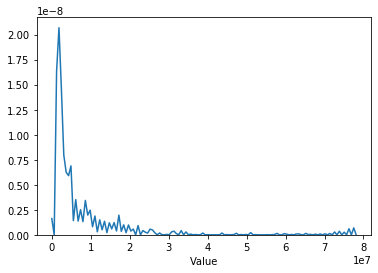

In [48]:
sns.distplot(df_useful["GDP"]["Value"], rug=False, hist=False)

As we later want to train some Machine Learning models, we log those values so that their distribution look a bit more like a normal distribution.

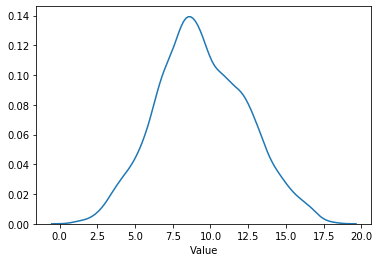

In [49]:
#looks better with log scale
sns.distplot(np.log(df_useful["GDP"]["Value"]), rug=False, hist=False)

The new distribution indeed looks better to train models on it.

### 1.F. Making one uniformized dataframe  <a name="1F"></a>

In this part, we will make one uniformized dataframe `uni_df` with the following columns.


    Country | Year | GDP | Crops production columns | Livestock production columns | Crops importation columns | Livestock importation columns | Crops exportation columns | Livestock exportation columns | CPI
    
In this uniformized dataframe, a tuple `(Country, Year)` uniquely identifies a row.


#### 1.F.a. Pivoting dataframes with items  <a name="1Fa"></a>

The current dataframes have several rows for a given `(Country, Year)`. Each of this row correspond to one item. We would like to have a unique row for a given `(Country, Year)` and one column per item:

In [50]:
need_pivot = ['Crops Area harvested',
              'Crops Production',
              'Crops Seed',
              'Crops Yield',
              'Livestock production',
              'Live animals import quantities',
              'Live animals export quantities',
              'Food import quantities',
              'Food export quantities']

def rename_columns(x, word):
    if x not in ['Area', 'Year', 'ha', 'tonnes', 'hg/ha', 'Head', '1000 Head']:
        return x + ' ' + word
    return x

df_useful['GDP'] = df_useful['GDP'].rename(columns = {'Value':'(GDP, million $)'})[["Area",'Year','(GDP, million $)']]
df_useful['Consumer price indices'] = df_useful['Consumer price indices'].rename(columns = {'Value':'(Consumer price indices, %)'})[["Area",'Year','(Consumer price indices, %)']]

for df_name in need_pivot :
    df_useful[df_name] = pd.pivot_table(df_useful[df_name], index=["Area",'Year'], columns=["Item","Unit"], values="Value").rename(columns=lambda x: rename_columns(x, df_name))
    display(df_useful[df_name].sample(5))

Item                Anise, badian, fennel, coriander Crops Area harvested  \
Unit                                                                   ha   
Area           Year                                                         
Mali           1981                                                NaN      
Benin          1970                                                NaN      
Ghana          2012                                                NaN      
Uganda         1999                                                NaN      
Eastern Europe 1963                                             2084.0      

Item                Apples Crops Area harvested Apricots Crops Area harvested  \
Unit                                         ha                            ha   
Area           Year                                                             
Mali           1981                         NaN                           NaN   
Benin          1970                         NaN                           NaN   
Ghana          2012                         NaN                           NaN   
Uganda         1999                         NaN                           NaN   
Eastern Europe 1963                    921513.0                       59967.0   

Item                Areca nuts Crops Area harvested  \
Unit                                             ha   
Area           Year                                   
Mali           1981                             NaN   
Benin          1970                             NaN   
Ghana          2012                             NaN   
Uganda         1999                             NaN   
Eastern Europe 1963                             NaN   

Item                Artichokes Crops Area harvested  \
Unit                                             ha   
Area           Year                                   
Mali           1981                             NaN   
Benin          1970                             NaN   
Ghana          2012                             NaN   
Uganda         1999                             NaN   
Eastern Europe 1963                             0.0   

Item                Asparagus Crops Area harvested  \
Unit                                            ha   
Area           Year                                  
Mali           1981                            NaN   
Benin          1970                            NaN   
Ghana          2012                            NaN   
Uganda         1999                            NaN   
Eastern Europe 1963                         1231.0   

Item                Avocados Crops Area harvested  \
Unit                                           ha   
Area           Year                                 
Mali           1981                           NaN   
Benin          1970                           NaN   
Ghana          2012                        1900.0   
Uganda         1999                           NaN   
Eastern Europe 1963                           NaN   

Item                Bambara beans Crops Area harvested  \
Unit                                                ha   
Area           Year                                      
Mali           1981                            12000.0   
Benin          1970                                NaN   
Ghana          2012                                NaN   
Uganda         1999                                NaN   
Eastern Europe 1963                                NaN   

Item                Bananas Crops Area harvested Barley Crops Area harvested  \
Unit                                          ha                          ha   
Area           Year                                                            
Mali           1981                        600.0                         NaN   
Benin          1970                       2200.0                         NaN   
Ghana          2012                       7600.0                         NaN   
Uganda         1999                     131715.0 

Item                             Anise, badian, fennel, coriander Crops Production  \
Unit                                                                        tonnes   
Area                        Year                                                     
United Republic of Tanzania 1963                                               NaN   
Timor-Leste                 1977                                               NaN   
Syria                       2014                                           27668.0   
Western Africa              1998                                               NaN   
Least Developed Countries   1974                                             630.0   

Item                             Apples Crops Production  \
Unit                                              tonnes   
Area                        Year                           
United Republic of Tanzania 1963                     NaN   
Timor-Leste                 1977                     NaN   
Syria                       2014                397858.0   
Western Africa              1998                     NaN   
Least Developed Countries   1974                 35300.0   

Item                             Apricots Crops Production  \
Unit                                                tonnes   
Area                        Year                             
United Republic of Tanzania 1963                       NaN   
Timor-Leste                 1977                       NaN   
Syria                       2014                   32008.0   
Western Africa              1998                       NaN   
Least Developed Countries   1974                   59430.0   

Item                             Areca nuts Crops Production  \
Unit                                                  tonnes   
Area                        Year                               
United Republic of Tanzania 1963                         NaN   
Timor-Leste                 1977                         NaN   
Syria                       2014                         NaN   
Western Africa              1998                         NaN   
Least Developed Countries   1974                     43264.0   

Item                             Artichokes Crops Production  \
Unit                                                  tonnes   
Area                        Year                               
United Republic of Tanzania 1963                         NaN   
Timor-Leste                 1977                         NaN   
Syria                       2014                      6800.0   
Western Africa              1998                         NaN   
Least Developed Countries   1974                         0.0   

Item                             Asparagus Crops Production  \
Unit                                                 tonnes   
Area                        Year                              
United Republic of Tanzania 1963                        NaN   
Timor-Leste                 1977                        NaN   
Syria                       2014                        NaN   
Western Africa              1998                        NaN   
Least Developed Countries   1974                        NaN   

Item                             Avocados Crops Production  \
Unit                                                tonnes   
Area                        Year                             
United Republic of Tanzania 1963                       NaN   
Timor-Leste                 1977                       NaN   
Syria                       2014                       NaN   
Western Africa              1998                   26951.0   
Least Developed Countries   1974                   87255.0   

Item                             Bambara beans Crops Production  \
Unit                                                     tonnes   
Area                        Year                                  
United Republic of Tanzania 1963                            NaN   
Timor-Leste                 1977     

Item           Anise, badian, fennel, coriander Crops Seed  \
Unit                                                tonnes   
Area      Year                                               
Norway    2006                                         NaN   
Indonesia 1961                                         NaN   
Guyana    1964                                         NaN   
Mongolia  1962                                         NaN   
Cambodia  1991                                         NaN   

Item           Bambara beans Crops Seed Bananas Crops Seed Barley Crops Seed  \
Unit                             tonnes             tonnes            tonnes   
Area      Year                                                                 
Norway    2006                      NaN                NaN           29800.0   
Indonesia 1961                      NaN                NaN               NaN   
Guyana    1964                      NaN                NaN               NaN   
Mongolia  1962                      NaN                NaN            2700.0   
Cambodia  1991                      NaN                NaN               NaN   

Item           Beans, dry Crops Seed Broad beans, horse beans, dry Crops Seed  \
Unit                          tonnes                                   tonnes   
Area      Year                                                                  
Norway    2006                   NaN                                      NaN   
Indonesia 1961               13600.0                                      NaN   
Guyana    1964                   NaN                                      0.0   
Mongolia  1962                   NaN                                      NaN   
Cambodia  1991                1120.0                                      NaN   

Item           Buckwheat Crops Seed Cabbages and other brassicas Crops Seed  \
Unit                         tonnes                                  tonnes   
Area      Year                                                                
Norway    2006                  NaN                                     NaN   
Indonesia 1961                  NaN                                     NaN   
Guyana    1964                  NaN                                     NaN   
Mongolia  1962                  NaN                                     NaN   
Cambodia  1991                  NaN                                     NaN   

Item           Carrots and turnips Crops Seed Cassava Crops Seed  ...  \
Unit                                   tonnes             tonnes  ...   
Area      Year                                                    ...   
Norway    2006                            NaN                NaN  ...   
Indonesia 1961                            NaN                NaN  ...   
Guyana    1964                            NaN                NaN  ...   
Mongolia  1962                            NaN                NaN  ...   
Cambodia  1991                            NaN                NaN  ...   

Item           Sorghum Crops Seed Soybeans Crops Seed Sugar cane Crops Seed  \
Unit                       tonnes              tonnes                tonnes   
Area      Year                                                                
Norway    2006                NaN                 NaN                   NaN   
Indonesia 1961                NaN             24000.0                   NaN   
Guyana    1964                NaN                 0.0                   NaN   
Mongolia  1962                NaN                 NaN                   NaN   
Cambodia  1991                NaN               640.0                7000.0   

Item           Sweet potatoes Crops Seed Taro (cocoyam) Crops Seed  \
Unit                              tonnes                    tonnes   
Area      Year                                                       
Norway    2006                       NaN                       NaN   
Indonesia 1961                  221733.0                       NaN   
Guyana    19

Item                                         Anise, badian, fennel, coriander Crops Yield  \
Unit                                                                                hg/ha   
Area                                    Year                                                
New Caledonia                           1985                                          NaN   
Net Food Importing Developing Countries 1991                                       8656.0   
Belarus                                 2005                                          NaN   
Kuwait                                  1981                                          NaN   
Ghana                                   1989                                          NaN   

Item                                         Apples Crops Yield  \
Unit                                                      hg/ha   
Area                                    Year                      
New Caledonia                           1985                NaN   
Net Food Importing Developing Countries 1991            91223.0   
Belarus                                 2005            35895.0   
Kuwait                                  1981                NaN   
Ghana                                   1989                NaN   

Item                                         Apricots Crops Yield  \
Unit                                                        hg/ha   
Area                                    Year                        
New Caledonia                           1985                  NaN   
Net Food Importing Developing Countries 1991              61060.0   
Belarus                                 2005                  NaN   
Kuwait                                  1981                  NaN   
Ghana                                   1989                  NaN   

Item                                         Areca nuts Crops Yield  \
Unit                                                          hg/ha   
Area                                    Year                          
New Caledonia                           1985                    NaN   
Net Food Importing Developing Countries 1991                 9188.0   
Belarus                                 2005                    NaN   
Kuwait                                  1981                    NaN   
Ghana                                   1989                    NaN   

Item                                         Artichokes Crops Yield  \
Unit                                                          hg/ha   
Area                                    Year                          
New Caledonia                           1985                    NaN   
Net Food Importing Developing Countries 1991               173842.0   
Belarus                                 2005                    NaN   
Kuwait                                  1981                    NaN   
Ghana                                   1989                    NaN   

Item                                         Asparagus Crops Yield  \
Unit                                                         hg/ha   
Area                                    Year                         
New Caledonia                           1985                   NaN   
Net Food Importing Developing Countries 1991               59825.0   
Belarus                                 2005                   NaN   
Kuwait                                  1981                   NaN   
Ghana                                   1989                   NaN   

Item                                         Avocados Crops Yield  \
Unit                                                        hg/ha   
Area                                    Year                        
New Caledonia                           1985                  NaN   
Net Food Importing Developing Countries 1991              79742.0   
Belarus                                 2005                  NaN   
Kuwait                                  1981        

Item         Animals live nes Livestock production Asses Livestock production  \
Unit                                          Head                       Head   
Area    Year                                                                    
Romania 1984                                   NaN                    35000.0   
Ukraine 2010                                   NaN                    12000.0   
Algeria 1976                                   NaN                   463260.0   
Togo    1963                                   NaN                      675.0   
Hungary 1987                             2197200.0                     4614.0   

Item         Beehives Livestock production Buffaloes Livestock production  \
Unit               No Livestock production                           Head   
Area    Year                                                                
Romania 1984                     1278700.0                            NaN   
Ukraine 2010                        3150.0                            NaN   
Algeria 1976                      182000.0                            NaN   
Togo    1963                           NaN                            NaN   
Hungary 1987                      693000.0                            NaN   

Item         Camelids, other Livestock production Camels Livestock production  \
Unit                                         Head                        Head   
Area    Year                                                                    
Romania 1984                                  NaN                         NaN   
Ukraine 2010                                  NaN                       800.0   
Algeria 1976                                  NaN                    140760.0   
Togo    1963                                  NaN                         NaN   
Hungary 1987                                  NaN                         NaN   

Item         Cattle Livestock production  \
Unit                                Head   
Area    Year                               
Romania 1984                   6752200.0   
Ukraine 2010                   4826700.0   
Algeria 1976                   1014720.0   
Togo    1963                    157975.0   
Hungary 1987                   1724700.0   

Item         Cattle and Buffaloes Livestock production  \
Unit                                              Head   
Area    Year                                             
Romania 1984                                 6752200.0   
Ukraine 2010                                 4826700.0   
Algeria 1976                                 1014720.0   
Togo    1963                                  157975.0   
Hungary 1987                                 1724700.0   

Item         Chickens Livestock production Ducks Livestock production  ...  \
Unit                             1000 Head                  1000 Head  ...   
Area    Year                                                           ...   
Romania 1984                      108506.0                     4600.0  ...   
Ukraine 2010                      172600.0                     9780.0  ...   
Algeria 1976                       16561.0                       24.0  ...   
Togo    1963                        1294.0                        NaN  ...   
Hungary 1987                       62070.0                     2011.0  ...   

Item         Horses Livestock production Mules Livestock production  \
Unit                                Head                       Head   
Area    Year                                                          
Romania 1984                    635000.0                        NaN   
Ukraine 2010                    443400.0                        NaN   
Algeria 1976                    139130.0                   188590.0   
Togo    1963                       749.0                        NaN   
Hungary 1987                     94700.0                      347.0   

Item         Pigeons, other birds Livestock production  \
Unit           

Item                 Animals live nes Live animals import quantities  \
Unit                                                            Head   
Area            Year                                                   
Bahrain         2012                                             NaN   
Southern Africa 1976                                             0.0   
Suriname        1983                                             NaN   
Bhutan          2001                                             0.0   
India           1983                                             NaN   

Item                 Asses Live animals import quantities  \
Unit                                                 Head   
Area            Year                                        
Bahrain         2012                                  NaN   
Southern Africa 1976                                104.0   
Suriname        1983                                  NaN   
Bhutan          2001                                  0.0   
India           1983                                  NaN   

Item                 Beehives Live animals import quantities  \
Unit                       No Live animals import quantities   
Area            Year                                           
Bahrain         2012                                     NaN   
Southern Africa 1976                                     NaN   
Suriname        1983                                     NaN   
Bhutan          2001                                     NaN   
India           1983                                     NaN   

Item                 Bovine, Animals Live animals import quantities  \
Unit                                                           Head   
Area            Year                                                  
Bahrain         2012                                         1285.0   
Southern Africa 1976                                       307571.0   
Suriname        1983                                            NaN   
Bhutan          2001                                            NaN   
India           1983                                          355.0   

Item                 Buffaloes Live animals import quantities  \
Unit                                                     Head   
Area            Year                                            
Bahrain         2012                                      NaN   
Southern Africa 1976                                      NaN   
Suriname        1983                                      NaN   
Bhutan          2001                                      NaN   
India           1983                                      NaN   

Item                 Camelids, other Live animals import quantities  \
Unit                                                           Head   
Area            Year                                                  
Bahrain         2012                                            NaN   
Southern Africa 1976                                            NaN   
Suriname        1983                                            NaN   
Bhutan          2001                                            NaN   
India           1983                                            NaN   

Item                 Camels Live animals import quantities  \
Unit                                                  Head   
Area            Year                                         
Bahrain         2012                                   2.0   
Southern Africa 1976                                   NaN   
Suriname        1983                                   NaN   
Bhutan          2001                                   NaN   
India           1983                                   NaN   

Item                 Cattle Live animals import quantities  \
Unit                                                  Head   
Area            Year                                         
Bahrain         2012                                1285.0   
Southern Africa 1

Item           Animals live nes Live animals export quantities  \
Unit                                                      Head   
Area      Year                                                   
Malaysia  1999                                             NaN   
Poland    2002                                             0.0   
Ireland   1990                                             NaN   
Sri Lanka 1977                                             0.0   
Barbados  1974                                             0.0   

Item           Asses Live animals export quantities  \
Unit                                           Head   
Area      Year                                        
Malaysia  1999                                  0.0   
Poland    2002                                  0.0   
Ireland   1990                                 36.0   
Sri Lanka 1977                                  NaN   
Barbados  1974                                  NaN   

Item           Beehives Live animals export quantities  \
Unit                 No Live animals export quantities   
Area      Year                                           
Malaysia  1999                                     NaN   
Poland    2002                                     NaN   
Ireland   1990                                     NaN   
Sri Lanka 1977                                     NaN   
Barbados  1974                                     NaN   

Item           Bovine, Animals Live animals export quantities  \
Unit                                                     Head   
Area      Year                                                  
Malaysia  1999                                          122.0   
Poland    2002                                       659477.0   
Ireland   1990                                       184855.0   
Sri Lanka 1977                                            0.0   
Barbados  1974                                           12.0   

Item           Buffaloes Live animals export quantities  \
Unit                                               Head   
Area      Year                                            
Malaysia  1999                                     12.0   
Poland    2002                                      NaN   
Ireland   1990                                      NaN   
Sri Lanka 1977                                      NaN   
Barbados  1974                                      NaN   

Item           Camelids, other Live animals export quantities  \
Unit                                                     Head   
Area      Year                                                  
Malaysia  1999                                            NaN   
Poland    2002                                            NaN   
Ireland   1990                                            NaN   
Sri Lanka 1977                                            NaN   
Barbados  1974                                            NaN   

Item           Camels Live animals export quantities  \
Unit                                            Head   
Area      Year                                         
Malaysia  1999                                   NaN   
Poland    2002                                   NaN   
Ireland   1990                                   NaN   
Sri Lanka 1977                                   NaN   
Barbados  1974                                   NaN   

Item           Cattle Live animals export quantities  \
Unit                                            Head   
Area      Year                                         
Malaysia  1999                                 110.0   
Poland    2002                              659477.0   
Ireland   1990                              184855.0   
Sri Lanka 1977                                   0.0   
Barbados  1974                                  12.0   

Item           Chickens Live animals export quantities       ...  \
Unit                                         1000 Head Head  ...   
Area      Year  

Item                           Alfalfa meal and pellets Crops import quantities  \
Unit                                                                     tonnes   
Area                      Year                                                    
Rwanda                    1991                                              NaN   
World                     1965                                         177575.0   
Least Developed Countries 1961                                              0.0   
Indonesia                 1966                                              0.0   
Western Asia              2011                                         819628.0   

Item                           Almonds shelled Crops import quantities  \
Unit                                                            tonnes   
Area                      Year                                           
Rwanda                    1991                                     NaN   
World                     1965                                 64718.0   
Least Developed Countries 1961                                     0.0   
Indonesia                 1966                                     0.0   
Western Asia              2011                                 60325.0   

Item                           Animal Oil+Fat+Grs Crops import quantities  \
Unit                                                               tonnes   
Area                      Year                                              
Rwanda                    1991                                      550.0   
World                     1965                                  1352816.0   
Least Developed Countries 1961                                    27777.0   
Indonesia                 1966                                        2.0   
Western Asia              2011                                   109077.0   

Item                           Animal Vegetable Oil Crops import quantities  \
Unit                                                                 tonnes   
Area                      Year                                                
Rwanda                    1991                                      15626.0   
World                     1965                                    5646931.0   
Least Developed Countries 1961                                     134103.0   
Indonesia                 1966                                       1305.0   
Western Asia              2011                                    5078329.0   

Item                           Animal fats Crops import quantities  \
Unit                                                        tonnes   
Area                      Year                                       
Rwanda                    1991                               550.0   
World                     1965                           1352816.0   
Least Developed Countries 1961                             27777.0   
Indonesia                 1966                                 2.0   
Western Asia              2011                            109077.0   

Item                           Anise, badian, fennel, coriander Crops import quantities  \
Unit                                                                             tonnes   
Area                      Year                                                            
Rwanda                    1991                                                NaN         
World                     1965                                            48427.0         
Least Developed Countries 1961                                              438.0         
Indonesia                 1966                                                0.0         
Western Asia              2011                                            41432.0         

Item                           Apples Crops import quantities  \
Unit                                                   tonnes   
Area                      Year                                  
Rwanda 

Item           Alfalfa meal and pellets Crops export quantities  \
Unit                                                     tonnes   
Area      Year                                                    
Sri Lanka 1972                                              NaN   
Togo      2002                                              NaN   
Rwanda    2010                                              NaN   
Honduras  2012                                              0.0   
Bahrain   1971                                              NaN   

Item           Almonds shelled Crops export quantities  \
Unit                                            tonnes   
Area      Year                                           
Sri Lanka 1972                                     NaN   
Togo      2002                                     NaN   
Rwanda    2010                                     NaN   
Honduras  2012                                    45.0   
Bahrain   1971                                     NaN   

Item           Animal Oil+Fat+Grs Crops export quantities  \
Unit                                               tonnes   
Area      Year                                              
Sri Lanka 1972                                        0.0   
Togo      2002                                        0.0   
Rwanda    2010                                        0.0   
Honduras  2012                                      191.0   
Bahrain   1971                                        0.0   

Item           Animal Vegetable Oil Crops export quantities  \
Unit                                                 tonnes   
Area      Year                                                
Sri Lanka 1972                                      86821.0   
Togo      2002                                      15203.0   
Rwanda    2010                                         23.0   
Honduras  2012                                     299786.0   
Bahrain   1971                                         99.0   

Item           Animal fats Crops export quantities  \
Unit                                        tonnes   
Area      Year                                       
Sri Lanka 1972                                 0.0   
Togo      2002                                 0.0   
Rwanda    2010                                 0.0   
Honduras  2012                               191.0   
Bahrain   1971                                 0.0   

Item           Anise, badian, fennel, coriander Crops export quantities  \
Unit                                                             tonnes   
Area      Year                                                            
Sri Lanka 1972                                                0.0         
Togo      2002                                                8.0         
Rwanda    2010                                                NaN         
Honduras  2012                                               24.0         
Bahrain   1971                                                NaN         

Item           Apples Crops export quantities  \
Unit                                   tonnes   
Area      Year                                  
Sri Lanka 1972                            0.0   
Togo      2002                            NaN   
Rwanda    2010                            NaN   
Honduras  2012                          125.0   
Bahrain   1971                          162.0   

Item           Apricots Crops export quantities  \
Unit                                     tonnes   
Area      Year                                    
Sri Lanka 1972                              0.0   
Togo      2002                              NaN   
Rwanda    2010                              0.0   
Honduras  2012                              0.0   
Bahrain   1971                              NaN   

Item           Apricots, dry Crops export quantities  \
Unit                                          tonnes   
Area      Year                                         


Some Nan values have appeared. As we have datasets that have great outliers, we would replace those Nan values by the median of the column:

In [51]:
# Deal with the NaN that appeared
for df_name in df_useful :
    for column in list(df_useful[df_name]):
        if column not in ['Area', 'Year']:
            df_useful[df_name][column].fillna(df_useful[df_name][column].median(), inplace=True)

In [52]:
#removing the multiindex, so that merge is clean with GDP and CPI
for df_name in need_pivot :
    df_useful[df_name].columns = [' '.join([str(_) for _ in v]) for v in df_useful[df_name].columns.values]
    display(df_useful[df_name].sample(5))
    

Anise, badian, fennel, coriander Crops Area harvested ha  \
Area                             Year                                                             
South Korea                      1974                                             3100.0          
Democratic Republic of the Congo 2004                                             3100.0          
Lebanon                          1984                                               15.0          
Philippines                      1966                                             3100.0          
Zambia                           1986                                             3100.0          

                                       Apples Crops Area harvested ha  \
Area                             Year                                   
South Korea                      1974                         27536.0   
Democratic Republic of the Congo 2004                         21040.0   
Lebanon                          1984                         10000.0   
Philippines                      1966                         21040.0   
Zambia                           1986                         21040.0   

                                       Apricots Crops Area harvested ha  \
Area                             Year                                     
South Korea                      1974                            5000.0   
Democratic Republic of the Congo 2004                            5000.0   
Lebanon                          1984                            3400.0   
Philippines                      1966                            5000.0   
Zambia                           1986                            5000.0   

                                       Areca nuts Crops Area harvested ha  \
Area                             Year                                       
South Korea                      1974                             49401.0   
Democratic Republic of the Congo 2004                             49401.0   
Lebanon                          1984                             49401.0   
Philippines                      1966                             49401.0   
Zambia                           1986                             49401.0   

                                       Artichokes Crops Area harvested ha  \
Area                             Year                                       
South Korea                      1974                              2800.0   
Democratic Republic of the Congo 2004                              2800.0   
Lebanon                          1984                               100.0   
Philippines                      1966                              2800.0   
Zambia                           1986                              2800.0   

                                       Asparagus Crops Area harvested ha  \
Area                             Year                                      
South Korea                      1974                             2173.0   
Democratic Republic of the Congo 2004                             2173.0   
Lebanon                          1984                             2173.0   
Philippines                      1966                             2173.0   
Zambia                           1986                             2173.0   

                                       Avocados Crops Area harvested ha  \
Area                             Year                                     
South Korea                      1974                            2729.0   
Democratic Republic of the Congo 2004                            8305.0   
Lebanon                          1984                            2729.0   
Philippines                      1966                            4000.0   
Zambia                           1986                            2729.0   

                                       Bambara beans Crops Area harvested ha  \
Area                             Year                                          
South Ko

Anise, badian, fennel, coriander Crops Production tonnes  \
Area                      Year                                                             
Mauritania                1991                                             2686.0          
Cyprus                    1962                                               30.0          
Solomon Islands           1969                                             2686.0          
Saint Pierre and Miquelon 1987                                             2686.0          
Mexico                    1985                                            17775.0          

                                Apples Crops Production tonnes  \
Area                      Year                                   
Mauritania                1991                        240418.5   
Cyprus                    1962                          1879.0   
Solomon Islands           1969                        240418.5   
Saint Pierre and Miquelon 1987                        240418.5   
Mexico                    1985                        423071.0   

                                Apricots Crops Production tonnes  \
Area                      Year                                     
Mauritania                1991                           27679.0   
Cyprus                    1962                             914.0   
Solomon Islands           1969                           27679.0   
Saint Pierre and Miquelon 1987                           27679.0   
Mexico                    1985                            3524.0   

                                Areca nuts Crops Production tonnes  \
Area                      Year                                       
Mauritania                1991                             30102.0   
Cyprus                    1962                             30102.0   
Solomon Islands           1969                             30102.0   
Saint Pierre and Miquelon 1987                             30102.0   
Mexico                    1985                             30102.0   

                                Artichokes Crops Production tonnes  \
Area                      Year                                       
Mauritania                1991                             21000.0   
Cyprus                    1962                              3650.0   
Solomon Islands           1969                             21000.0   
Saint Pierre and Miquelon 1987                             21000.0   
Mexico                    1985                                25.0   

                                Asparagus Crops Production tonnes  \
Area                      Year                                      
Mauritania                1991                             7905.5   
Cyprus                    1962                             7905.5   
Solomon Islands           1969                             7905.5   
Saint Pierre and Miquelon 1987                             7905.5   
Mexico                    1985                            24616.0   

                                Avocados Crops Production tonnes  \
Area                      Year                                     
Mauritania                1991                           15422.5   
Cyprus                    1962                              45.0   
Solomon Islands           1969                           15422.5   
Saint Pierre and Miquelon 1987                           15422.5   
Mexico                    1985                          566451.0   

                                Bambara beans Crops Production tonnes  \
Area                      Year                                          
Mauritania                1991                                25100.0   
Cyprus                    1962                                25100.0   
Solomon Islands           1969                                25100.0   
Saint Pierre and Miquelon 1987                                25100.0   
Mexico                    1985                                2510

Anise, badian, fennel, coriander Crops Seed tonnes  \
Area                  Year                                                       
India                 1973                                                0.0    
Asia                  1999                                                4.0    
China                 2006                                                0.0    
Sao Tome and Principe 1963                                                0.0    
Colombia              1971                                                0.0    

                            Bambara beans Crops Seed tonnes  \
Area                  Year                                    
India                 1973                           1268.0   
Asia                  1999                           1268.0   
China                 2006                           1268.0   
Sao Tome and Principe 1963                           1268.0   
Colombia              1971                           1268.0   

                            Bananas Crops Seed tonnes  \
Area                  Year                              
India                 1973                        0.0   
Asia                  1999                        0.0   
China                 2006                        0.0   
Sao Tome and Principe 1963                        0.0   
Colombia              1971                        0.0   

                            Barley Crops Seed tonnes  \
Area                  Year                             
India                 1973                  198000.0   
Asia                  1999                 1728656.0   
China                 2006                   81144.0   
Sao Tome and Principe 1963                   28600.0   
Colombia              1971                    5715.0   

                            Beans, dry Crops Seed tonnes  \
Area                  Year                                 
India                 1973                      250830.0   
Asia                  1999                      473332.0   
China                 2006                       79115.5   
Sao Tome and Principe 1963                        3120.0   
Colombia              1971                        5499.0   

                            Broad beans, horse beans, dry Crops Seed tonnes  \
Area                  Year                                                    
India                 1973                                           1115.5   
Asia                  1999                                         127065.0   
China                 2006                                         101010.0   
Sao Tome and Principe 1963                                           1115.5   
Colombia              1971                                              0.0   

                            Buckwheat Crops Seed tonnes  \
Area                  Year                                
India                 1973                       1305.0   
Asia                  1999                     124671.0   
China                 2006                      78750.0   
Sao Tome and Principe 1963                       1305.0   
Colombia              1971                       1305.0   

                            Cabbages and other brassicas Crops Seed tonnes  \
Area                  Year                                                   
India                 1973                                          4000.0   
Asia                  1999                                          4000.0   
China                 2006                                          4000.0   
Sao Tome and Principe 1963                                          4000.0   
Colombia              1971                                          4000.0   

                            Carrots and turnips Crops Seed tonnes  \
Area                  Year                                          
India                 1973                                11669.0   
Asia                  1999                                11669.0   
China 

Anise, badian, fennel, coriander Crops Yield hg/ha  \
Area      Year                                                       
Slovakia  1994                                             7948.0    
Iceland   1975                                             7948.0    
Nepal     1969                                             7948.0    
Gambia    1989                                             7948.0    
Mauritius 2009                                             7948.0    

                Apples Crops Yield hg/ha  Apricots Crops Yield hg/ha  \
Area      Year                                                         
Slovakia  1994                  138504.0                     44335.0   
Iceland   1975                  100000.0                     65534.0   
Nepal     1969                  100000.0                     65534.0   
Gambia    1989                  100000.0                     65534.0   
Mauritius 2009                  100000.0                     65534.0   

                Areca nuts Crops Yield hg/ha  Artichokes Crops Yield hg/ha  \
Area      Year                                                               
Slovakia  1994                       10559.0                      104578.0   
Iceland   1975                       10559.0                      104578.0   
Nepal     1969                       10559.0                      104578.0   
Gambia    1989                       10559.0                      104578.0   
Mauritius 2009                       10559.0                      104578.0   

                Asparagus Crops Yield hg/ha  Avocados Crops Yield hg/ha  \
Area      Year                                                            
Slovakia  1994                      50000.0                     70391.0   
Iceland   1975                      38812.0                     70391.0   
Nepal     1969                      38812.0                     70391.0   
Gambia    1989                      38812.0                     70391.0   
Mauritius 2009                      38812.0                     70391.0   

                Bambara beans Crops Yield hg/ha  Bananas Crops Yield hg/ha  \
Area      Year                                                               
Slovakia  1994                           7074.0                   115741.5   
Iceland   1975                           7074.0                   115741.5   
Nepal     1969                           7074.0                   115741.5   
Gambia    1989                           7074.0                   115741.5   
Mauritius 2009                           7074.0                   221053.0   

                Barley Crops Yield hg/ha  ...  \
Area      Year                            ...   
Slovakia  1994                   36717.0  ...   
Iceland   1975                   17858.0  ...   
Nepal     1969                    9141.0  ...   
Gambia    1989                   17858.0  ...   
Mauritius 2009                   17858.0  ...   

                Sweet potatoes Crops Yield hg/ha  \
Area      Year                                     
Slovakia  1994                           71071.0   
Iceland   1975                           71071.0   
Nepal     1969                           71071.0   
Gambia    1989                           71071.0   
Mauritius 2009                          123377.0   

                Tangerines, mandarins, clementines, satsumas Crops Yield hg/ha  \
Area      Year                                                                   
Slovakia  1994                                           120000.0                
Iceland   1975                                           120000.0                
Nepal     1969                                           120000.0                
Gambia    1989                                           120000.0                
Mauritius 2009                                           120000.0                

                Taro (cocoyam) Crops Yield hg/ha  Tomatoes Crops Yield hg/ha  \
Area      Year                      

Animals live nes Livestock production Head  \
Area               Year                                               
Seychelles         1965                                    532303.0   
Cyprus             1971                                    532303.0   
Lesotho            1996                                    532303.0   
Melanesia          1963                                    532303.0   
Belgium-Luxembourg 1997                                    532303.0   

                         Asses Livestock production Head  \
Area               Year                                    
Seychelles         1965                          37836.0   
Cyprus             1971                          46000.0   
Lesotho            1996                         153200.0   
Melanesia          1963                          37836.0   
Belgium-Luxembourg 1997                          37836.0   

                         Beehives Livestock production No Livestock production  \
Area               Year                                                          
Seychelles         1965                                           187000.0       
Cyprus             1971                                            40700.0       
Lesotho            1996                                           187000.0       
Melanesia          1963                                              400.0       
Belgium-Luxembourg 1997                                            29000.0       

                         Buffaloes Livestock production Head  \
Area               Year                                        
Seychelles         1965                             288416.0   
Cyprus             1971                             288416.0   
Lesotho            1996                             288416.0   
Melanesia          1963                             288416.0   
Belgium-Luxembourg 1997                             288416.0   

                         Camelids, other Livestock production Head  \
Area               Year                                              
Seychelles         1965                                  4380000.0   
Cyprus             1971                                  4380000.0   
Lesotho            1996                                  4380000.0   
Melanesia          1963                                  4380000.0   
Belgium-Luxembourg 1997                                  4380000.0   

                         Camels Livestock production Head  \
Area               Year                                     
Seychelles         1965                          240000.0   
Cyprus             1971                          240000.0   
Lesotho            1996                          240000.0   
Melanesia          1963                          240000.0   
Belgium-Luxembourg 1997                          240000.0   

                         Cattle Livestock production Head  \
Area               Year                                     
Seychelles         1965                            1500.0   
Cyprus             1971                           35500.0   
Lesotho            1996                          539000.0   
Melanesia          1963                          298065.0   
Belgium-Luxembourg 1997                         3280000.0   

                         Cattle and Buffaloes Livestock production Head  \
Area               Year                                                   
Seychelles         1965                                          1500.0   
Cyprus             1971                                         35500.0   
Lesotho            1996                                        539000.0   
Melanesia          1963                                        298065.0   
Belgium-Luxembourg 1997                                       3280000.0   

                         Chickens Livestock production 1000 Head  \
Area               Year                                            
Seychelles         1965                                     50.0   
Cypru

Animals live nes Live animals import quantities Head  \
Area                      Year                                                         
Poland                    1991                                                0.0      
EU(27)ex.int              2013                                                5.0      
Least Developed Countries 2012                                                0.0      
Barbados                  1996                                                0.0      
Nauru                     1996                                                0.0      

                                Asses Live animals import quantities Head  \
Area                      Year                                              
Poland                    1991                                        0.0   
EU(27)ex.int              2013                                      115.0   
Least Developed Countries 2012                                     1703.0   
Barbados                  1996                                        0.0   
Nauru                     1996                                        0.0   

                                Beehives Live animals import quantities No Live animals import quantities  \
Area                      Year                                                                              
Poland                    1991                                                0.0                           
EU(27)ex.int              2013                                               55.0                           
Least Developed Countries 2012                                                0.0                           
Barbados                  1996                                                0.0                           
Nauru                     1996                                                0.0                           

                                Bovine, Animals Live animals import quantities Head  \
Area                      Year                                                        
Poland                    1991                                            41200.0     
EU(27)ex.int              2013                                             1939.0     
Least Developed Countries 2012                                           731608.0     
Barbados                  1996                                               16.0     
Nauru                     1996                                             2066.0     

                                Buffaloes Live animals import quantities Head  \
Area                      Year                                                  
Poland                    1991                                            0.0   
EU(27)ex.int              2013                                            0.0   
Least Developed Countries 2012                                        49281.0   
Barbados                  1996                                            0.0   
Nauru                     1996                                            0.0   

                                Camelids, other Live animals import quantities Head  \
Area                      Year                                                        
Poland                    1991                                               12.0     
EU(27)ex.int              2013                                               12.0     
Least Developed Countries 2012                                               12.0     
Barbados                  1996                                               12.0     
Nauru                     1996                                               12.0     

                                Camels Live animals import quantities Head  \
Area                      Year                                               
Poland                    1991                                         0.0   
EU(27)ex.int              2013                                       143.0   
Least Devel

Animals live nes Live animals export quantities Head  \
Area                              Year                                                         
USSR                              1983                                                0.0      
Guatemala                         1966                                                0.0      
Malta                             1989                                                0.0      
Switzerland                       2007                                                0.0      
Low Income Food Deficit Countries 1974                                                0.0      

                                        Asses Live animals export quantities Head  \
Area                              Year                                              
USSR                              1983                                        0.0   
Guatemala                         1966                                        0.0   
Malta                             1989                                        0.0   
Switzerland                       2007                                        0.0   
Low Income Food Deficit Countries 1974                                     6045.0   

                                        Beehives Live animals export quantities No Live animals export quantities  \
Area                              Year                                                                              
USSR                              1983                                                0.0                           
Guatemala                         1966                                                0.0                           
Malta                             1989                                                0.0                           
Switzerland                       2007                                                0.0                           
Low Income Food Deficit Countries 1974                                                0.0                           

                                        Bovine, Animals Live animals export quantities Head  \
Area                              Year                                                        
USSR                              1983                                             1700.0     
Guatemala                         1966                                              178.0     
Malta                             1989                                                0.0     
Switzerland                       2007                                             4446.0     
Low Income Food Deficit Countries 1974                                           813152.0     

                                        Buffaloes Live animals export quantities Head  \
Area                              Year                                                  
USSR                              1983                                            0.0   
Guatemala                         1966                                            0.0   
Malta                             1989                                            0.0   
Switzerland                       2007                                            0.0   
Low Income Food Deficit Countries 1974                                         8000.0   

                                        Camelids, other Live animals export quantities Head  \
Area                              Year                                                        
USSR                              1983                                                7.0     
Guatemala                         1966                                                7.0     
Malta                             1989                                                7.0     
Switzerland                       2007                                                7.0     
Low Income Food Deficit Countries 1974                                                7.0  

Alfalfa meal and pellets Crops import quantities tonnes  \
Area      Year                                                            
Laos      2005                                               46.0         
Qatar     1975                                               46.0         
Finland   2013                                             1570.0         
Nicaragua 1993                                               46.0         
Europe    1970                                           290475.0         

                Almonds shelled Crops import quantities tonnes  \
Area      Year                                                   
Laos      2005                                            93.5   
Qatar     1975                                            93.5   
Finland   2013                                           931.0   
Nicaragua 1993                                            93.5   
Europe    1970                                         60023.0   

                Animal Oil+Fat+Grs Crops import quantities tonnes  \
Area      Year                                                      
Laos      2005                                                0.0   
Qatar     1975                                                2.0   
Finland   2013                                            23613.0   
Nicaragua 1993                                            17091.0   
Europe    1970                                           784009.0   

                Animal Vegetable Oil Crops import quantities tonnes  \
Area      Year                                                        
Laos      2005                                               14.0     
Qatar     1975                                              718.0     
Finland   2013                                           153826.0     
Nicaragua 1993                                            58854.0     
Europe    1970                                          4325913.0     

                Animal fats Crops import quantities tonnes  \
Area      Year                                               
Laos      2005                                         0.0   
Qatar     1975                                         2.0   
Finland   2013                                     23613.0   
Nicaragua 1993                                     17091.0   
Europe    1970                                    784009.0   

                Anise, badian, fennel, coriander Crops import quantities tonnes  \
Area      Year                                                                    
Laos      2005                                                0.0                 
Qatar     1975                                              167.0                 
Finland   2013                                              113.0                 
Nicaragua 1993                                               18.0                 
Europe    1970                                            11949.0                 

                Apples Crops import quantities tonnes  \
Area      Year                                          
Laos      2005                                 1870.0   
Qatar     1975                                    0.0   
Finland   2013                                44576.0   
Nicaragua 1993                                 1107.0   
Europe    1970                              1674394.0   

                Apricots Crops import quantities tonnes  \
Area      Year                                            
Laos      2005                                     21.0   
Qatar     1975                                     21.0   
Finland   2013                                    526.0   
Nicaragua 1993                                     17.0   
Europe    1970                                  69296.0   

                Apricots, dry Crops import quantities tonnes  \
Area      Year                                                 
Laos      2005                                          22.0   
Qatar     1975        

Alfalfa meal and pellets Crops export quantities tonnes  \
Area                              Year                                                            
Low Income Food Deficit Countries 1981                                                0.0         
New Zealand                       1968                                                0.0         
Swaziland                         1994                                               32.0         
Guinea-Bissau                     2008                                               32.0         
Pakistan                          1994                                               32.0         

                                        Almonds shelled Crops export quantities tonnes  \
Area                              Year                                                   
Low Income Food Deficit Countries 1981                                             0.0   
New Zealand                       1968                                             0.0   
Swaziland                         1994                                             9.0   
Guinea-Bissau                     2008                                             9.0   
Pakistan                          1994                                             1.0   

                                        Animal Oil+Fat+Grs Crops export quantities tonnes  \
Area                              Year                                                      
Low Income Food Deficit Countries 1981                                              683.0   
New Zealand                       1968                                            77313.0   
Swaziland                         1994                                              223.0   
Guinea-Bissau                     2008                                              223.0   
Pakistan                          1994                                                0.0   

                                        Animal Vegetable Oil Crops export quantities tonnes  \
Area                              Year                                                        
Low Income Food Deficit Countries 1981                                           411726.0     
New Zealand                       1968                                            77398.0     
Swaziland                         1994                                             8632.0     
Guinea-Bissau                     2008                                               42.0     
Pakistan                          1994                                             5316.0     

                                        Animal fats Crops export quantities tonnes  \
Area                              Year                                               
Low Income Food Deficit Countries 1981                                       683.0   
New Zealand                       1968                                     77313.0   
Swaziland                         1994                                       223.0   
Guinea-Bissau                     2008                                       223.0   
Pakistan                          1994                                         0.0   

                                        Anise, badian, fennel, coriander Crops export quantities tonnes  \
Area                              Year                                                                    
Low Income Food Deficit Countries 1981                                            15931.0                 
New Zealand                       1968                                                0.0                 
Swaziland                         1994                                               36.5                 
Guinea-Bissau                     2008                                               36.5                 
Pakistan                          1994                                              863.0                 

                                        Appl

#### 1.F.b. Merging everything  <a name="1Fb"></a>
We are now creating the uniformized dataframe `uni_df`. Each row corresponds to one tuple `(Country, Year)` so that we can later group by country or year. In addition to the country ("Area") and the "Year", the columns will either be an economic feature ("GDP", "CPI") or an agricultural one (some crop harvested area, some livestock export quantity, ...)

In [53]:
uni_df = df_useful['GDP']
for df_name in need_pivot :
    uni_df = pd.merge(uni_df, df_useful[df_name], how='outer', on=['Area', 'Year'])
uni_df = pd.merge(uni_df,df_useful['Consumer price indices'], how='outer', on=['Area', 'Year'])

# Deal with the NaN that appeared
for column in list(uni_df):
    if column not in ['Area', 'Year']:
        uni_df[column].fillna(uni_df[column].median(), inplace=True)
uni_df.sample(30)

Area  Year  (GDP, million $)  \
7286                             Romania  1983      4.761579e+04   
12892                            Lebanon  1965      1.008410e+04   
7252                 Republic of Moldova  1995      1.766956e+03   
12248                           Djibouti  1969      1.008410e+04   
5507                               Malta  1998      3.975721e+03   
8906                                Togo  1993      1.412817e+03   
494                            Australia  2004      6.780124e+05   
10667                               Asia  2006      1.295673e+07   
6778                              Panama  1981      4.565383e+03   
6848                    Papua New Guinea  2005      7.312285e+03   
2204                          Costa Rica  2007      2.674387e+04   
13009                         Martinique  1983      1.008410e+04   
13228                            Nigeria  1968      1.008410e+04   
14344        Falkland Islands (Malvinas)  2012      1.008410e+04   
11557  Low Income Food Deficit Countries  1976      3.184033e+05   
10901                       Western Asia  2010      2.483544e+06   
11848                 Belgium-Luxembourg  1968      1.008410e+04   
6663                                Oman  2004      2.476371e+04   
7957                           Singapore  2010      2.364203e+05   
11673                            Algeria  1964      1.008410e+04   
1837                               Chile  2013      2.770787e+05   
14961                        Saint Lucia  2017      1.008410e+04   
2614    Democratic Republic of the Congo  2003      8.937649e+03   
5263                          Madagascar  1984      2.939419e+03   
5179                           Lithuania  1992      8.050692e+03   
14842                              Italy  2016      1.008410e+04   
13058                          Mauritius  1969      1.008410e+04   
6326                       New Caledonia  1989      2.185083e+03   
8205                        South Africa  1982      7.912143e+04   
1027                              Bhutan  1985      1.722032e+02   

       Anise, badian, fennel, coriander Crops Area harvested ha  \
7286                                              3100.0          
12892                                               50.0          
7252                                              3100.0          
12248                                             3100.0          
5507                                              3100.0          
8906                                              3100.0          
494                                                533.0          
10667                                           637167.0          
6778                                              3100.0          
6848                                              3100.0          
2204                                              3100.0          
13009                                             3100.0          
13228                                             3100.0          
14344                                             3100.0          
11557                                           155840.0          
10901                                            85732.0          
11848                                             3100.0          
6663                                              3100.0          
7957                                              3100.0          
11673                                             3100.0          
1837                                              3100.0          
14961                                             3100.0          
2614                                              3100.0          
5263                                                20.0          
5179                                              3100.0          
14842                                             3100.0          
13058                                             3100.0          
6326                                              3

### 2. Data exploration and first observations  <a name="2"></a>

2. 
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Consumer price indices](#2B)      
                
    3. [Structure of international trade and historical context](#2C)       
        
    4. [Economic classification of countries](#2D)  
        
In this part, we will explore the dataset with more details. We will first see in more detail the [food productions, importations and exportations](#2A), next examine the [Consumer price indices](#2B), then study the [structure of international trade and historical context](#2C) and finally look at the [economic classification of countries](#2D).

#### 2.A. Food productions, importations and exportations <a name="2A"></a>

2. 
        
    1. 
    
        1. [Crops and livestock production and trade](#2Aa)  
    
            1. [Crops](#2Aai)
            
                1. [Production](#2Aai1)
                
                2. [Importation](#2Aai2)
                
                3. [Exportation](#2Aai3)
    
            2. [Livestock](#2Aaii)  
            
                1. [Production](#2Aaii1)
                
                2. [Importation](#2Aaii2)
                
                3. [Exportation](#2Aaii3)
    
            2. [Globally](#2Aaiii)             
    
        2. [Introducing the concept of food self-sufficiency](#2Ab)
    
            1. [Basic idea](#2Abi)
    
            2. [Formula and computation](#2Abii)

##### 2.A.a Crops and livestock production and trade <a name="2Aa"></a>
TODO

##### 2.A.b Introducing the concept of food self-sufficiency <a name="2Ab"></a>
In this section we will present and compute the notion of food self-sufficiency.
###### 2.A.b.i Basic idea <a name="2Abi"></a>
One may wonder how to know whether a country produce all the food it needs or not. The notion of food-self-sufficency allows to answer to this question. More formally, it is a rate that decribes how much does a country can satisfy to meet its internal consumption needs by production. It describes the extent to which a country is able to feed its population through its domestic food production.  We are interested into this measure since we think it could be correlated with the economic conditions of this country.
###### 2.A.b.ii Formula and computation <a name="2Abii"></a>
In order to compute the food self-sufficiency, we will apply the following formula that gives us the food self-sudfficiency as a percentage :

$$\frac{Production \times 100}{Production + Imports – Exports}$$

In [54]:
all_columns = list(uni_df)
production_columns = []
import_columns = []
export_columns = []
for column in all_columns:
    if (type(column)==tuple) and column[1]=='tonnes':
        if 'export quantities' in column[0]:
            export_columns.append(column)
        elif 'import quantities' in column[0]:
            import_columns.append(column)
        elif 'Production' in column[0]:
            production_columns.append(column)
            
uni_df[('All productions','tonnes')] = 0
for column in production_columns :
    uni_df[('All productions','tonnes')] += uni_df[column]            
uni_df[('All imports','tonnes')] = 0
for column in import_columns :
    uni_df[('All imports','tonnes')] += uni_df[column]            
uni_df[('All exports','tonnes')] = 0
for column in export_columns :
    uni_df[('All exports','tonnes')] += uni_df[column]
            
uni_df[('food self-sufficiency','%')] = 100 * uni_df[('All productions','tonnes')] / (uni_df[('All productions','tonnes')]+uni_df[('All imports','tonnes')]+uni_df[('All exports','tonnes')])


In [55]:
display(uni_df[['Area','Year',('food self-sufficiency','%')]].sample(5))

Area  Year  (food self-sufficiency, %)
7330                      Russia  1981                         NaN
2946                 El Salvador  2013                         NaN
11237                  Melanesia  1978                         NaN
11994                 Cabo Verde  1967                         NaN
14111  Wallis and Futuna Islands  1962                         NaN

In [56]:
plot = uni_df[['Area','Year']]
plot["Value"] = uni_df[('food self-sufficiency','%')]
for year in range(1980, 2010, 5):
    display(year, visualise_world_data_folium(plot, year, False))
    

C:\Users\nanil\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1980

1985

1990

1995

2000

2005

#### 2.B. Consumer price indices  <a name="2B"></a>

2. 
        
    2. 
    
        1. [Definition](#2Ba) 
    
        2. [Usage](#2Bb)      
        
##### 2.B.a. Definition  <a name="2Ba"></a>

Consumer price indices (CPI) are a way to measure the changes of the average price level of goods. One can use it to measure inflation or deflation over some period. More technically, for a given item, the CPI is the ratio of the market basket fo two different years. Global CPI is an average of sigle item CPI with some standardized weights.


##### 2.B.b. Usage  <a name="2Bb"></a>

The CPI have many usages and is often taken into consideration. For instance it is used for budget and pensions revisions, monetary and economic policies, and economic analysis .

We will use the CPI to answer the following questions: "Are prices more stables in more self-sufficient countries ?", "Is there a link between the CPI and the agricultural features ?" 

#### 2.C. Structure of international trade and historical context  <a name="2C"></a>


Our dataset contains data for the historical period from 1970 to 2015. In order to be able to correctly interpret the results we are going to see, we first made an historical research on this period. We shortly listed below important events of this period for which we think they have had a significant influence on the agriculture and the economy.

There was the Cold war from 1945 to 1990 with two economic superpowers (USA and USSR). The USSR had been dissoluted in 1991.  The Japanese economic miracle occured from 1945 to 1990 and allowed Japan to come out of the disastrous state in which it was at the exit of the WW2 and become world's second largest economy. There has been 2 big oil crisis in 1973 and 1979. There has been many wars (Middle East wars 1973-2000 e.g. Yom Kippur War 1973, Islamic Revolution in Iran 1979, Iran–Iraq war 1980-1988, Gulf war 1990-1991, Yugoslav wars 1991-2001...). We have already seen some consequences of such events by dealing with countries names in a previous section.

The third Agricultural Revolution (also known as Green revolution) occurs form 1960 to 1990 and imporved agricultural productions thanks to fertilizers and chemicals.

The following public-domain image from [Wikimedia](https://commons.wikimedia.org/wiki/File:Imf-advanced-un-least-developed-2008.svg) represents developed countries (blue), developing ones (orange) and least developed ones (red) according to the United Nations and International Monetary Fund. We expect to see similar results with our dataset (GDP).
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Imf-advanced-un-least-developed-2008.svg/1920px-Imf-advanced-un-least-developed-2008.svg.png">

The following image, also from [Wikimedia](https://commons.wikimedia.org/wiki/File:Cumulative_Current_Account_Balance.png) shows the cumulative commercial balance for the period 1980-2008. We also expect to see similar results with our dataset, but there might be difference as we focus on agriculture.
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Cumulative_Current_Account_Balance.png/800px-Cumulative_Current_Account_Balance.png">


In order to have an idea of the international trade and economy structure, we are interested in GDP: 

In [57]:
pivoted_GDP_df = uni_df[['Area','Year']]
pivoted_GDP_df["GDP"] = uni_df["(GDP, million $)"]
pivoted_GDP_df = pivoted_GDP_df.pivot_table(index='Year', columns='Area', values="GDP").dropna(axis=1)

C:\Users\nanil\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [58]:
pivoted_GDP_df.sample(5)

Area   Afghanistan       Albania       Algeria        Angola      Argentina  \
Year                                                                          
2002   4285.170218   4355.865889  56819.210891  15285.592487  110583.590320   
1998   2911.960069   2554.868838  48079.007974   8617.787964  324135.104740   
1992   3474.600007   1516.091306  49105.553595  18586.043395  247929.419770   
1966  10084.100000  10084.100000  10084.100000  10084.100000   10084.100000   
1973   1733.333275   2466.543461   9229.622200   5016.276328   41468.218535   

Area         Aruba      Australia        Austria       Bahrain    Bangladesh  \
Year                                                                           
2002   1941.094724  435040.918200  212980.372720   9593.509106  47194.755390   
1998   1665.363128  389641.889780  217678.366080   6997.873038  42676.520395   
1992    958.463200  326052.615150  194601.848280   5432.210287  30690.544964   
1966  10084.100000   10084.100000   10084.100000  10084.100000  10084.100000   
1973    206.410064   85620.821841   29443.659831    820.273128   6771.633529   

Area  ...         Turkey        Uganda  United Arab Emirates  United Kingdom  \
Year  ...                                                                      
2002  ...  232530.484890   7410.282948         109816.091080    1.757510e+06   
1998  ...  269262.054300   7490.865855          75674.384205    1.623501e+06   
1992  ...  213862.708500   3757.923640          54239.188746    1.179713e+06   
1966  ...   10084.100000  10084.100000          10084.100000    1.008410e+04   
1973  ...   36384.876325   2003.215931           4212.630478    1.925517e+05   

Area  United Republic of Tanzania  United States of America       Uruguay  \
Year                                                                        
2002                 14140.007894                10977514.0  13606.503907   
1998                 12362.402801                 9089168.0  25385.887793   
1992                  7058.981548                 6539300.0  14222.511106   
1966                 10084.100000                   10084.1  10084.100000   
1973                  3539.275358                 1428500.0   3128.676886   

Area       Vietnam        Zambia      Zimbabwe  
Year                                            
2002  35064.105501   4193.839169   7111.380000  
1998  27209.602050   3537.731099   8401.386477  
1992   9866.997753   3307.307865   9031.473178  
1966  10084.100000  10084.100000  10084.100000  
1973   3350.311755   2349.834205   3552.268490  

[5 rows x 146 columns]

As we can see on a subset of the correlation matrix below, GDP are often hugely correlated between countries. 

In [59]:
selected_countries = ['Algeria', 'Australia', 'Austria', 'Bangladesh', 'China',
                      'Djibouti', 'France', 'Germany', 'India', 'Japan', 'Mali',
                      'Switzerland', 'United States of America']

corr = pivoted_GDP_df[selected_countries].corr()
corr.style.background_gradient(cmap='coolwarm')

The correlation matrix contains lots of values that are very closed to one (red). This is also true for the whole correlation matrix as seen below:

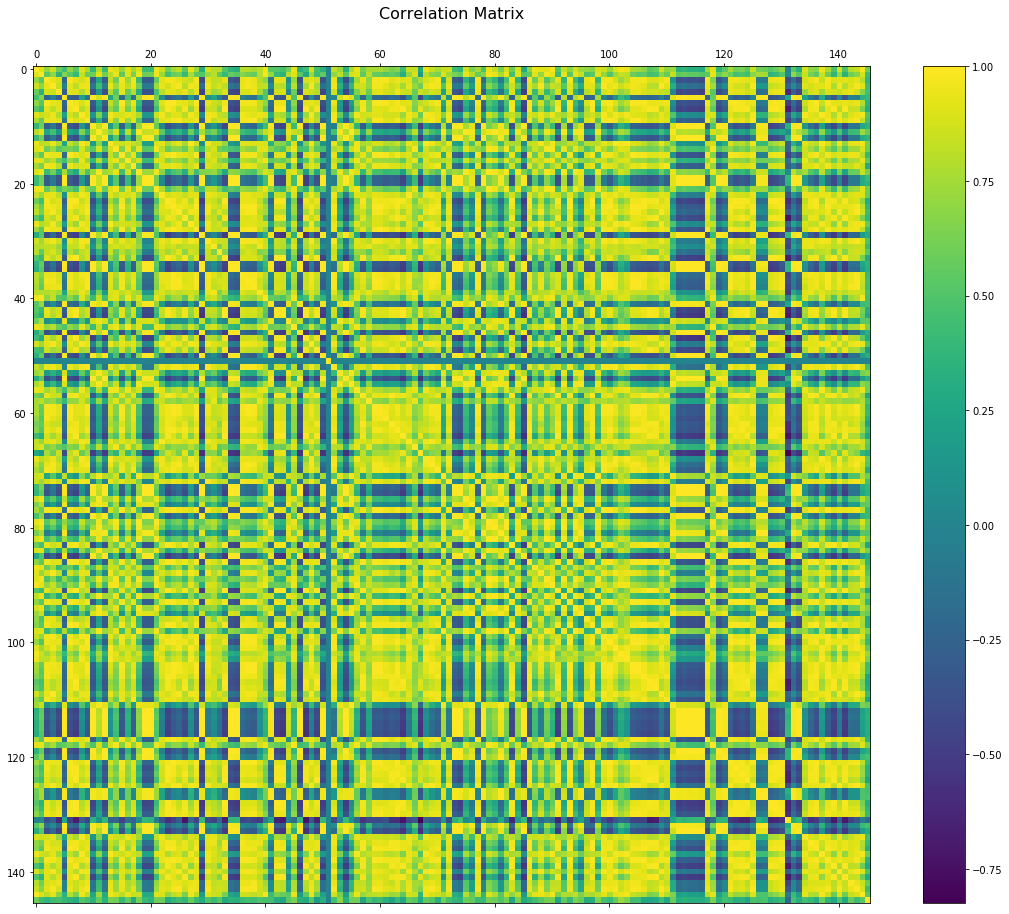

In [60]:
f = plt.figure(figsize=(19, 15))
plt.matshow(pivoted_GDP_df.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Correlation Matrix', fontsize=16);

We then try to clusterize this correlation matrix in order to find countries whose GDP are correlated:

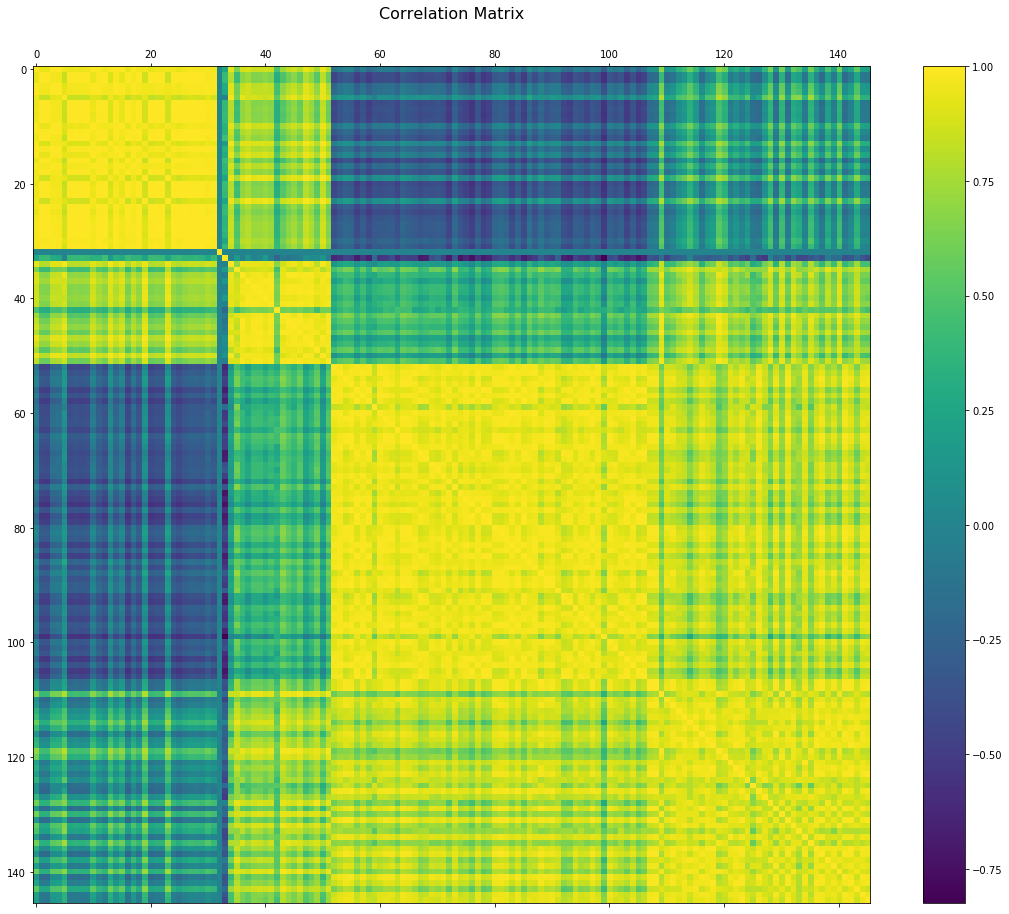

In [61]:
corr = pivoted_GDP_df.corr().values
pdist = spc.distance.pdist(corr)   # vector of ('55' choose 2) pairwise distances
linkage = spc.linkage(pdist, method='complete')
ind = spc.fcluster(linkage, 0.5*pdist.max(), 'distance')
columns = [pivoted_GDP_df.columns.tolist()[i] for i in list((np.argsort(ind)))]
clusterised_df = pivoted_GDP_df.reindex(columns, axis=1)

f = plt.figure(figsize=(19, 15))
plt.matshow(clusterised_df.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Correlation Matrix', fontsize=16);

We have found 4 regions in which the GDP is highly correlated and between which the correlation coefficent is lower. We could refine the big clusters by iterating this method.

**Interpretation:** The correlation matrix of GDP contains lots of values that are very closed to one. This means that GDP in two different countries have a trend to evolve the same way. Therefore, we can say that the world countries have strong enough trading relations to make the GDP evolve the same way. The fact that we have found some main clusters could be interpreted as regions in which the trading relations are more important.

#### 2.D. Economic classification of countries <a name="2D"></a>

In [62]:
plot = uni_df[['Area','Year']]
plot["Value"] = uni_df["(GDP, million $)"]
for year in range(1980, 2015, 5):
    display(year, visualise_world_data_folium(plot, year, True))

C:\Users\nanil\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1980

1985

1990

1995

2000

2005

2010

### 3. Descriptive data analysis  <a name="3"></a>

3. 

    1. [Production and consumption of food from a time-space geography point of view](#3A)
        
        1. [Net food exporters or importers](#3Aa)
        
        2. [Evolution over the last few decades](#3Ab)

    1. [Food self-sufficiency](#3B)

    2. [Analysis of food production and trade with GDP](#3C)
        
        1. [Correlation between production features and GDP](#3Ca)
        
        2. [Correlation between food trade features and GDP](#3Cb)
        
        2. [Machine learning model](#3Cc)  

    3. [Food prices stability and agricultural features](#3C)  
    
TODO

#### 3.Ca. Food production and GDP <a name="3Ca"></a>

Out of the crops and the livestock produced, we will focus on the top 20 crops as well as top 20 livestock produced globally to be able to have a model with a reasonable amount of feautures. 

In [105]:
#Choose the top 20 crops produced in the world for the first model
crop_production_df= uni_df.filter(like='Crops Production tonnes') 
crop_production_df = crop_production_df.sum(axis=0).sort_values(ascending=False)
crop_production_list = crop_production_df.index.tolist()[:20]
crop_production_list.insert(0,'(GDP, million $)')
crop_production_list
#Take the top 20 crops and the columns of our uni_df which contain their production
maincrops_df = uni_df[crop_production_list]

#Livestock
livestock_production_df= uni_df.filter(like='Livestock production') 
livestock_production_df = livestock_production_df.sum(axis=0).sort_values(ascending=False)
livestock_production_list = livestock_production_df.index.tolist()[:20]
livestock_production_list.insert(0,'(GDP, million $)')
livestock_production_list
#Take the top 20 crops and the columns of our uni_df which contain their production
mainlivestock_df = uni_df[livestock_production_list]

top_production_list = crop_production_list +livestock_production_list[1:]

top_production_df = uni_df[top_production_list]
top_production_df.head(5)

(GDP, million $)  Cereals (Rice Milled Eqv) Crops Production tonnes  \
0       1748.886597                                          3390122.0   
1       1831.108982                                          3202450.0   
2       1595.555482                                          3816800.0   
3       1733.333275                                          4130140.0   
4       2155.555500                                          4211140.0   

   Sugar cane Crops Production tonnes  \
0                             55000.0   
1                             50000.0   
2                             35000.0   
3                             58000.0   
4                             51600.0   

   Roots and Tubers,Total Crops Production tonnes  \
0                                        144000.0   
1                                        167000.0   
2                                        158000.0   
3                                        165000.0   
4                                        182000.0   

   Vegetables&Melons, Total Crops Production tonnes  \
0                                          482000.0   
1                                          558000.0   
2                                          500000.0   
3                                          515000.0   
4                                          518000.0   

   Wheat Crops Production tonnes  Rice, paddy Crops Production tonnes  \
0                      2081000.0                             366000.0   
1                      1915000.0                             350000.0   
2                      2450000.0                             400000.0   
3                      2700000.0                             420000.0   
4                      2750000.0                             420000.0   

   Maize Crops Production tonnes  \
0                       667000.0   
1                       670000.0   
2                       720000.0   
3                       760000.0   
4                       770000.0   

   Fruit excl Melons,Total Crops Production tonnes  \
0                                         794600.0   
1                                         634800.0   
2                                         781400.0   
3                                         822500.0   
4                                         847500.0   

   Sugar beet Crops Production tonnes  ...  Asses Livestock production Head  \
0                             62000.0  ...                        1300000.0   
1                             60000.0  ...                        1300000.0   
2                             63300.0  ...                        1300000.0   
3                             57000.0  ...                        1250000.0   
4                             66600.0  ...                        1250000.0   

   Camels Livestock production Head  \
0                          300000.0   
1                          300000.0   
2                          300000.0   
3                          300000.0   
4                          300000.0   

   Animals live nes Livestock production Head  \
0                                    532303.0   
1                                    532303.0   
2                                    532303.0   
3                                    532303.0   
4                                    532303.0   

   Mules Livestock production Head  \
0                          35000.0   
1                          35000.0   
2                          31000.0   
3                          26500.0   
4                          26500.0   

   Poultry Birds Livestock production 1000 Head  \
0                                        6000.0   
1                                        6000.0   
2                                        6000.0   
3                                        6100.0   
4                                        6100.0   

   Chickens Livestock production 1000 Head  \
0                                   6000.0   
1                                   6000.0   
2

In [106]:
#Checking correlations of main crops between each other and with GDP
mainprod_correlation_matrix = round (top_production_df.corr(method='pearson'),3)
mainprod_correlation_matrix['(GDP, million $)'].sort_values(ascending = False)



(GDP, million $)                                         1.000
Maize Crops Production tonnes                            0.837
Tomatoes Crops Production tonnes                         0.833
Chickens Livestock production 1000 Head                  0.832
Poultry Birds Livestock production 1000 Head             0.828
Citrus Fruit,Total Crops Production tonnes               0.806
Cereals (Rice Milled Eqv) Crops Production tonnes        0.797
Fruit excl Melons,Total Crops Production tonnes          0.792
Wheat Crops Production tonnes                            0.777
Soybeans Crops Production tonnes                         0.754
Vegetables&Melons, Total Crops Production tonnes         0.742
Turkeys Livestock production 1000 Head                   0.741
Bananas Crops Production tonnes                          0.700
Pigs Livestock production Head                           0.697
Sugar cane Crops Production tonnes                       0.689
Rabbits and hares Livestock production 1000 Head       

Because "Cereals (Rice Milled Eqv) Crops Production tonnes" has such a high correlation with a lot of other features, it is probably an aggregate of them (eg over 90% with wheat).

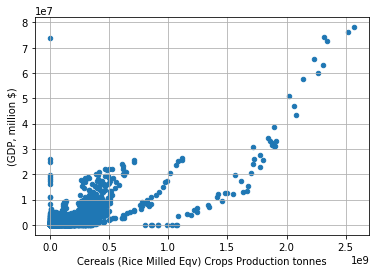

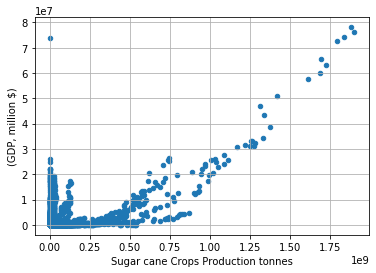

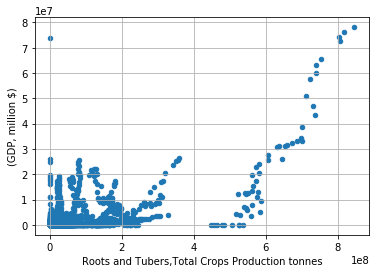

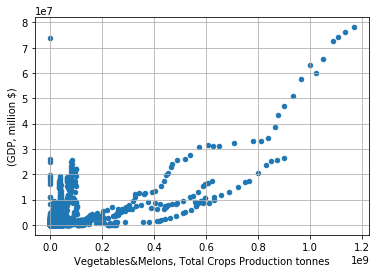

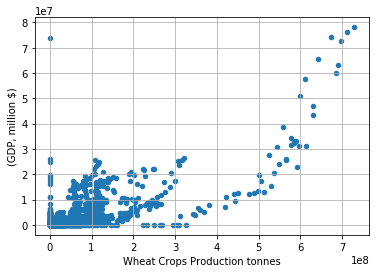

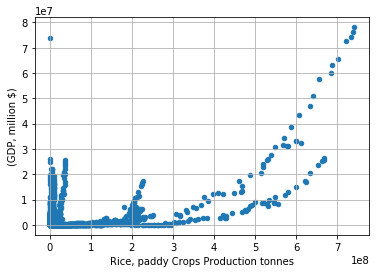

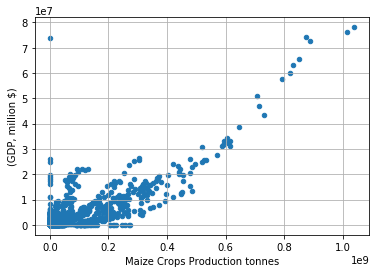

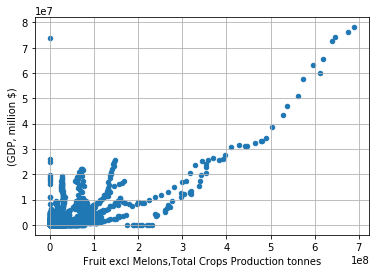

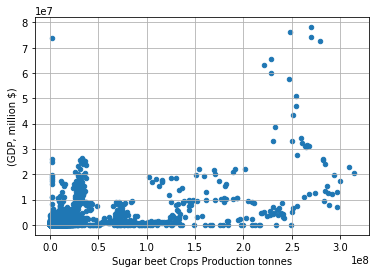

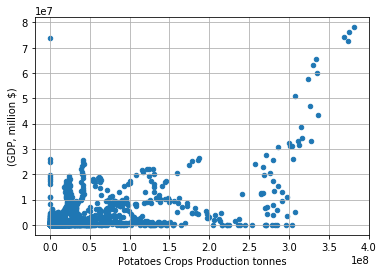

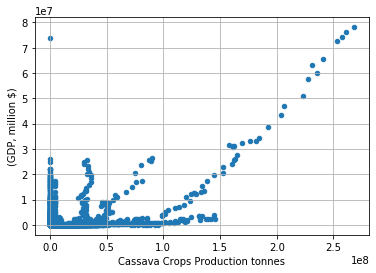

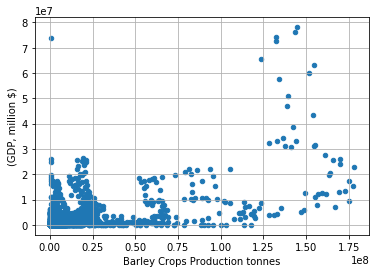

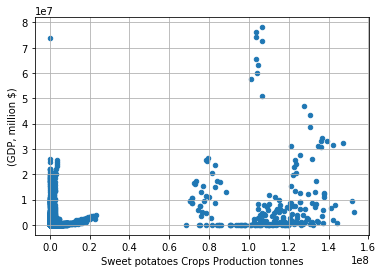

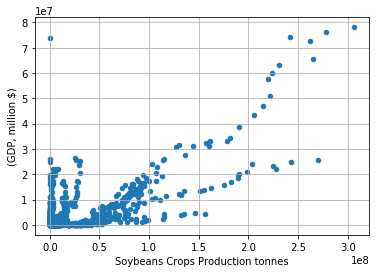

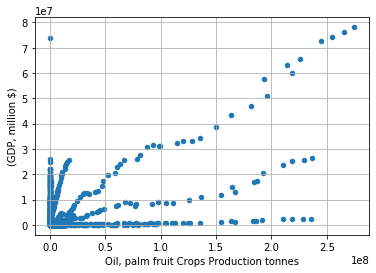

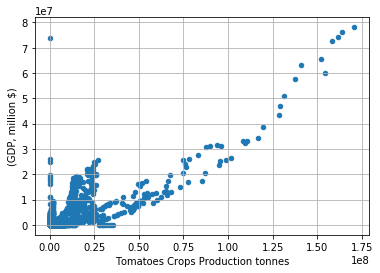

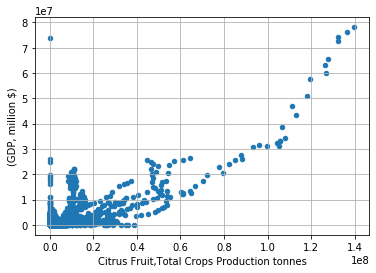

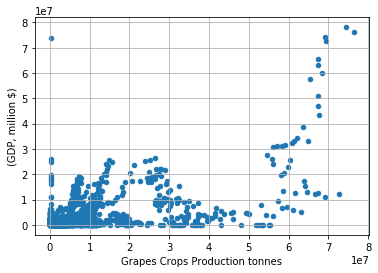

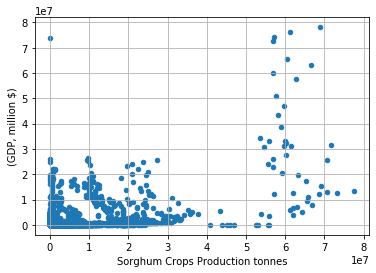

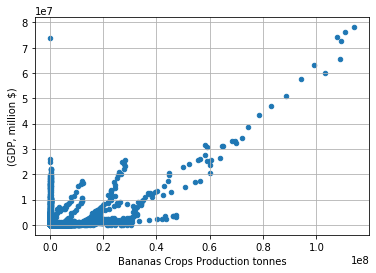

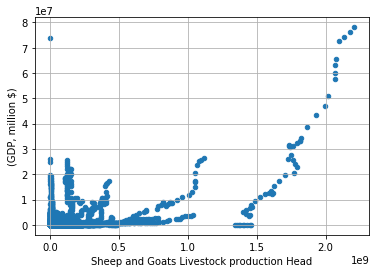

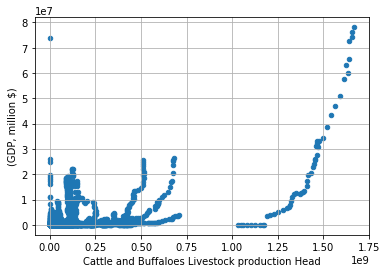

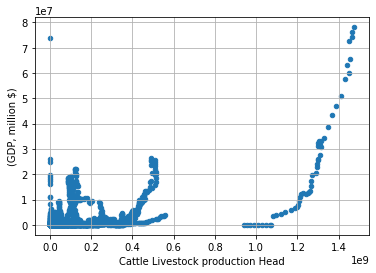

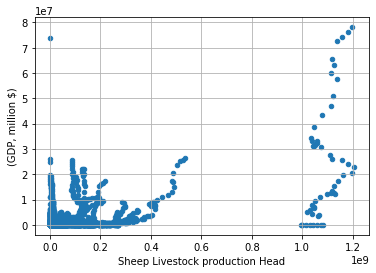

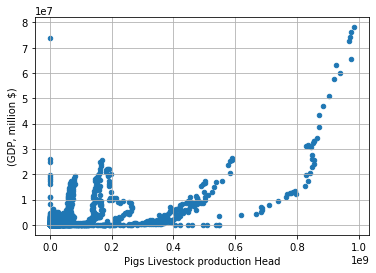

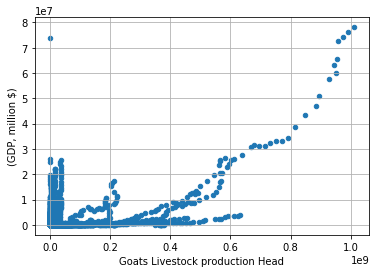

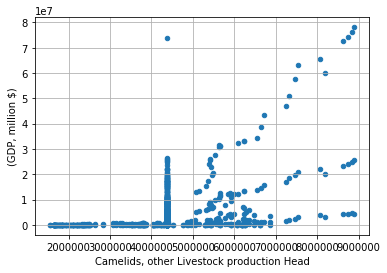

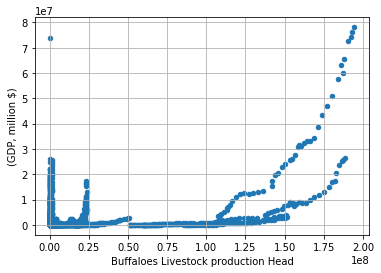

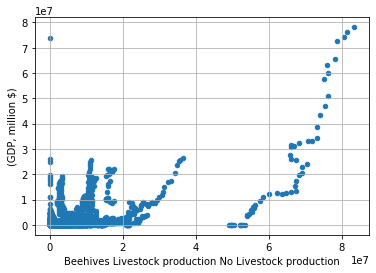

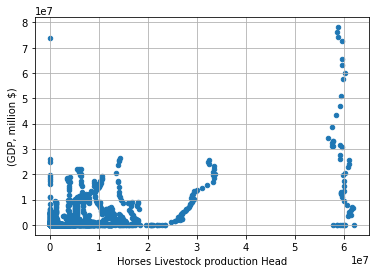

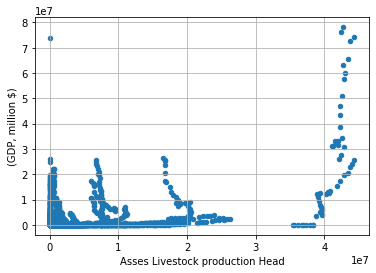

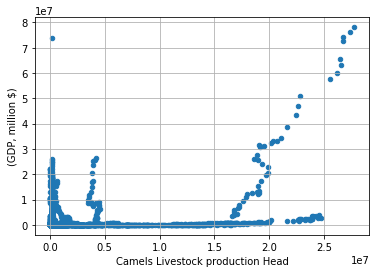

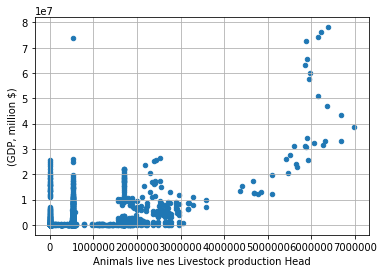

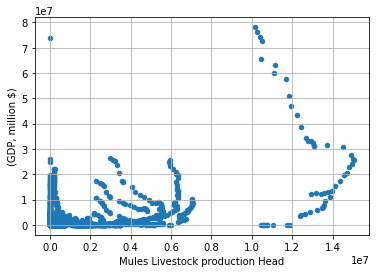

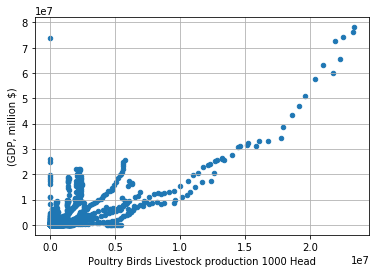

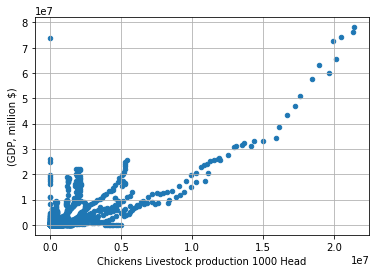

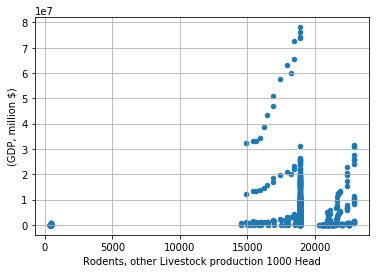

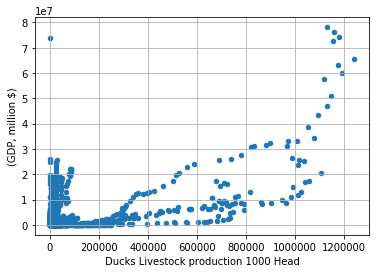

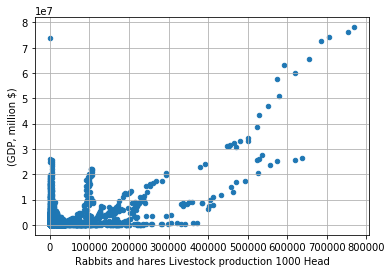

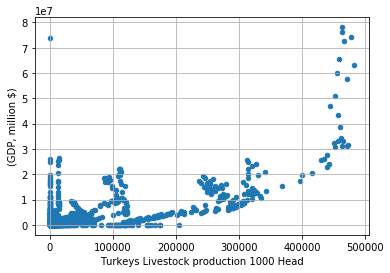

In [107]:
#Looking at some relationships
for item in list(top_production_df.columns)[1:]:
    top_production_df.plot(kind='scatter', x=item, y='(GDP, million $)', grid=True)


We can quite clearly see that the production of many of the most popular crops can well be related to GDP.

#### 3.C.b. Trade and GDP <a name="3Cb"></a>

Let's see if the same can be said about the most exported/imported goods.

In [80]:
#Choose the top 20 most exported items by mass
top_exports_df= uni_df.filter(like='export quantities tonnes')
top_exports_df = top_exports_df.sum(axis=0).sort_values(ascending=False)
top_exports_list =top_exports_df.index.tolist()[:20]
top_exports_list

#Take the top 20 exported crops and the columns of our uni_df which contain their production
top_exports_list.insert(0,'(GDP, million $)')
top_exports_df = uni_df[top_exports_list]


#Choose the top 20 most imported items by mass
top_imports_df= uni_df.filter(like='import quantities tonnes')
top_imports_df = top_imports_df.sum(axis=0).sort_values(ascending=False)

top_imports_list =top_imports_df.index.tolist()[:20]
top_imports_list

#Take the top 20 imported items and the columns of our uni_df which contain their production
top_imports_list.insert(0,'(GDP, million $)')
top_imports_df = uni_df[top_imports_list]

#Create a joined list
top_traded_list = top_exports_list +top_imports_list[1:]

In [81]:

top_traded_df = uni_df[top_traded_list]
top_traded_df.head(5)

(GDP, million $)  Cereals Crops export quantities tonnes  \
0       1748.886597                                 20000.0   
1       1831.108982                                 20000.0   
2       1595.555482                                 20000.0   
3       1733.333275                                 20000.0   
4       2155.555500                                 20000.0   

   Wheat+Flour,Wheat Equivalent Crops export quantities tonnes  \
0                                             2511.0             
1                                             2511.0             
2                                             2511.0             
3                                             2511.0             
4                                             2511.0             

   Wheat Crops export quantities tonnes  \
0                                 623.0   
1                                 623.0   
2                                 623.0   
3                                 623.0   
4                                 623.0   

   Fodder & Feeding stuff Crops export quantities tonnes  \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                                0.0       

   Maize Crops export quantities tonnes  \
0                                 900.0   
1                                 900.0   
2                                 900.0   
3                                 900.0   
4                                 900.0   

   Milk Equivalent Crops export quantities tonnes  \
0                                          3617.5   
1                                          3617.5   
2                                          3617.5   
3                                          3617.5   
4                                          3617.5   

   Sugar and Honey Crops export quantities tonnes  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   

   Oilseeds Crops export quantities tonnes  \
0                                   7229.0   
1                                   3456.0   
2                                  34541.0   
3                                  27678.0   
4                                  18490.0   

   Oilseed Cake Meal Crops export quantities tonnes  ...  \
0                                               0.0  ...   
1                                               0.0  ...   
2                                               0.0  ...   
3                                               0.0  ...   
4                                               0.0  ...   

   Cake, soybeans Crops import quantities tonnes  \
0                                        19731.0   
1                                        19731.0   
2                                        19731.0   
3                                        19731.0   
4                                        19731.0   

   Animal Vegetable Oil Crops import quantities tonnes  \
0                                             8286.0     
1                                            11763.0     
2                                            14471.0     
3                                            10279.0     
4                                            11017.0     

   Sugar,Total (Raw Equiv.) Crops import quantities tonnes  \
0                                            57611.0         
1                                            49413.0         
2                                            46332.0         
3                                            60959.0         
4                                            54024.0         

   Beverages Crops import quantities 

In [82]:
#Checking correlations of main traded goods between each other and with GDP
top_traded_correlation_matrix = round (top_traded_df.corr(method='pearson'),3)
top_traded_correlation_matrix['(GDP, million $)'].sort_values(ascending = False)


(GDP, million $)                                                         1.000
Total Meat Crops export quantities tonnes                                0.827
Fodder & Feeding stuff Crops export quantities tonnes                    0.823
Animal Vegetable Oil Crops import quantities tonnes                      0.806
Fixed Vegetable Oils Crops import quantities tonnes                      0.797
Milk Equivalent Crops import quantities tonnes                           0.779
Sugar and Honey Crops import quantities tonnes                           0.768
Cereals Crops export quantities tonnes                                   0.759
Animal Vegetable Oil Crops export quantities tonnes                      0.758
Oilseed Cake Meal Crops export quantities tonnes                         0.758
Beverages Crops import quantities tonnes                                 0.755
Oilseeds Crops export quantities tonnes                                  0.749
Sugar,Total (Raw Equiv.) Crops import quantities ton

It seems that the most high correlations can be found from  exports of meat as well as feeding stuff. 

C:\Users\nanil\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


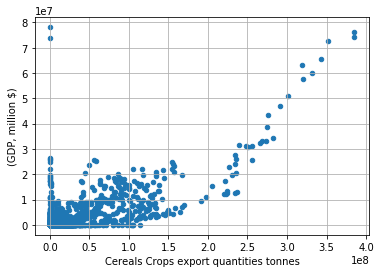

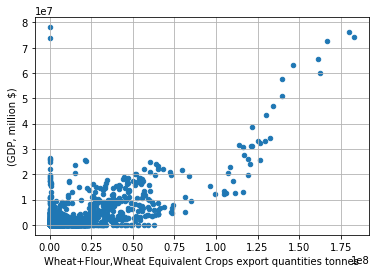

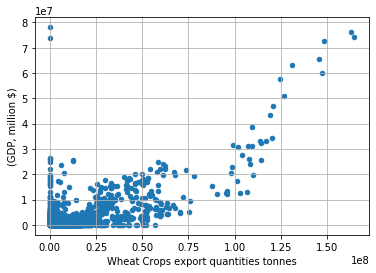

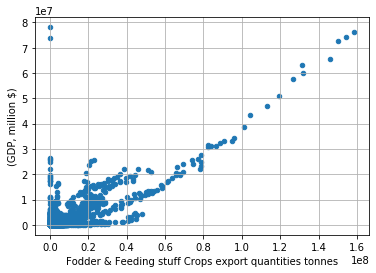

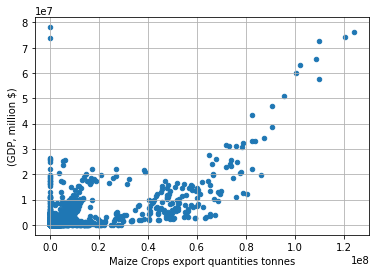

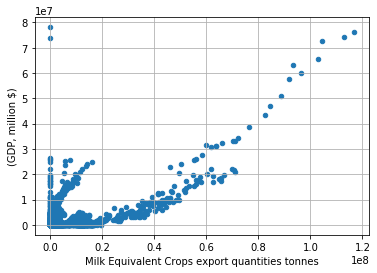

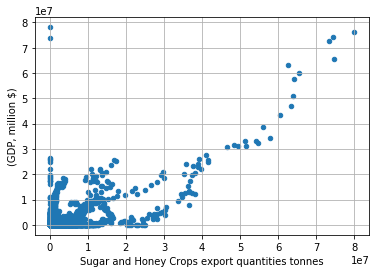

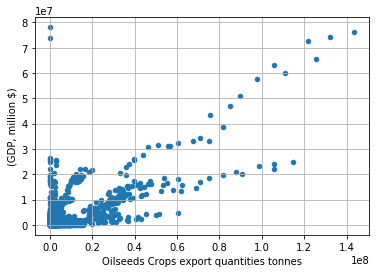

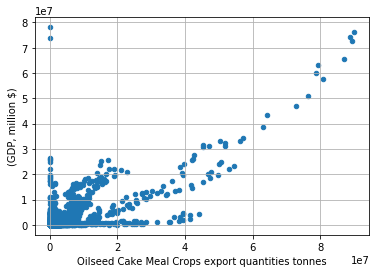

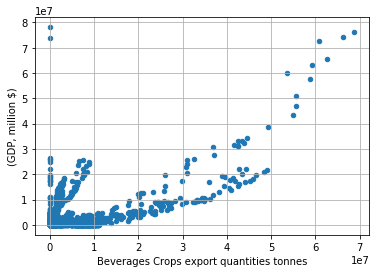

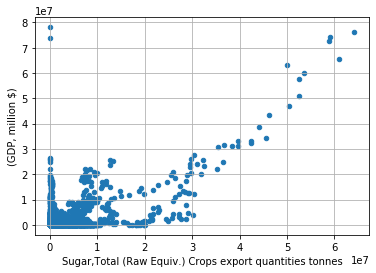

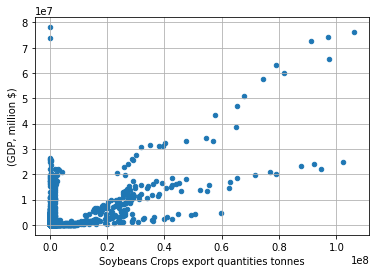

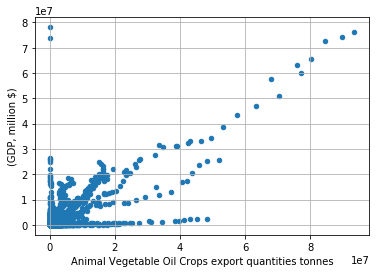

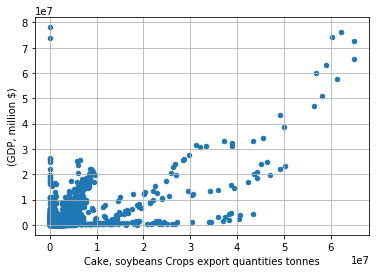

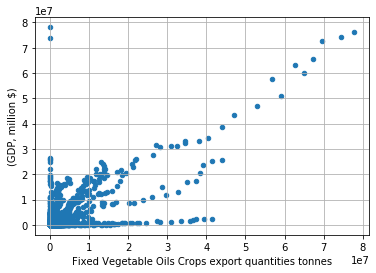

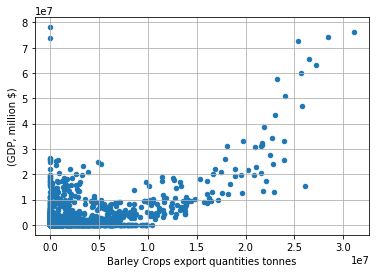

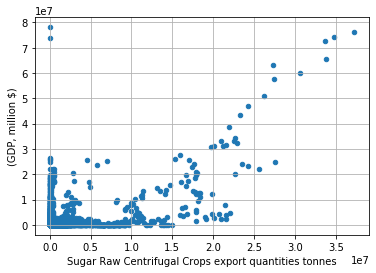

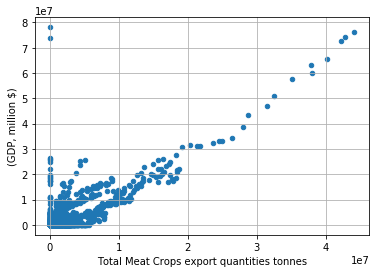

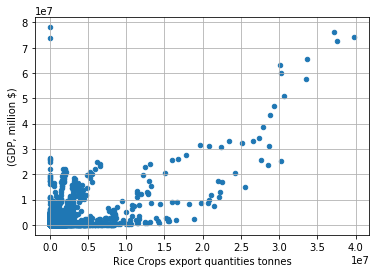

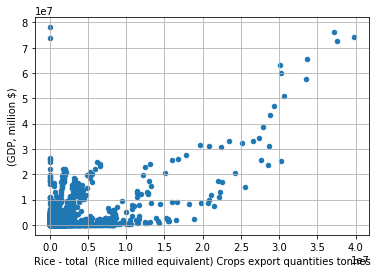

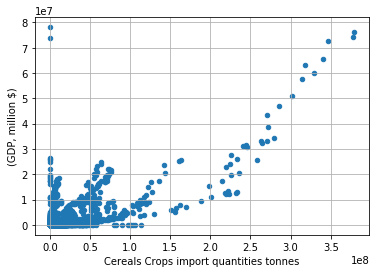

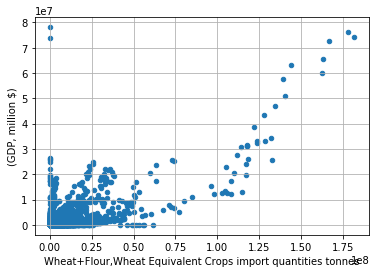

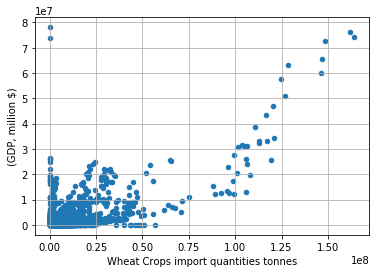

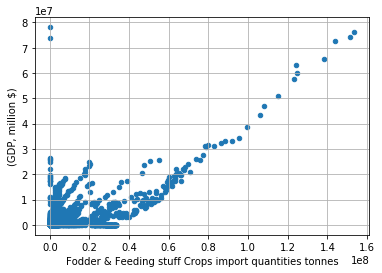

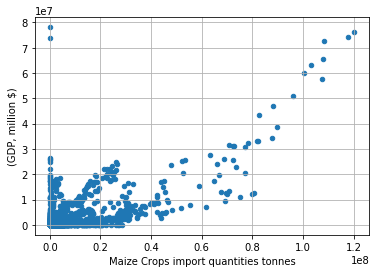

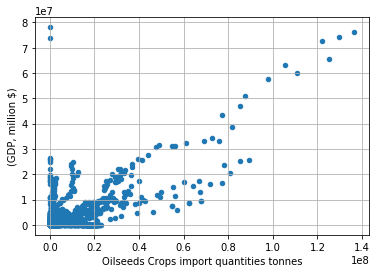

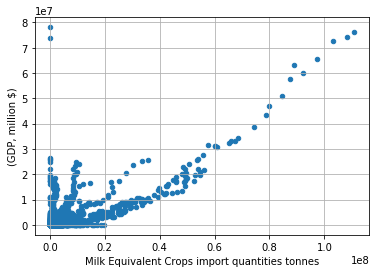

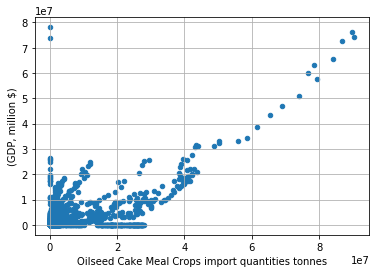

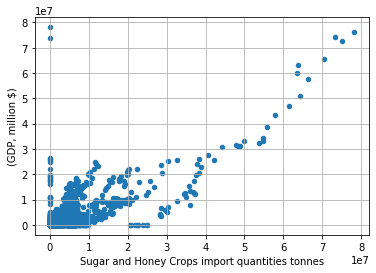

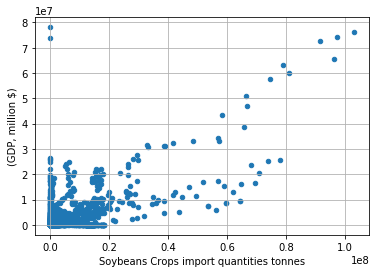

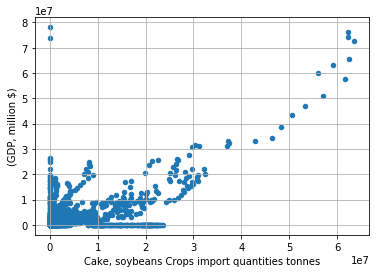

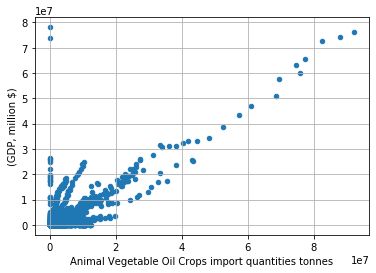

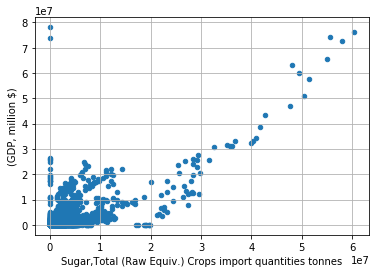

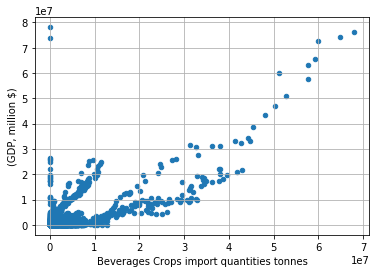

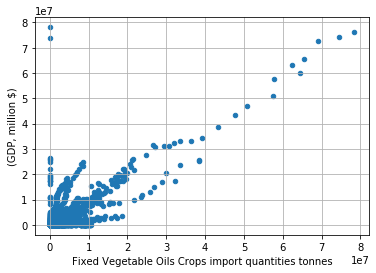

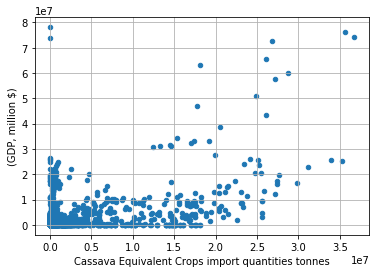

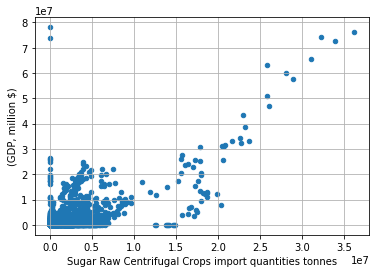

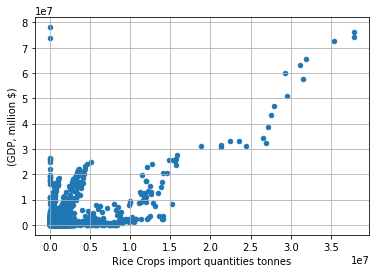

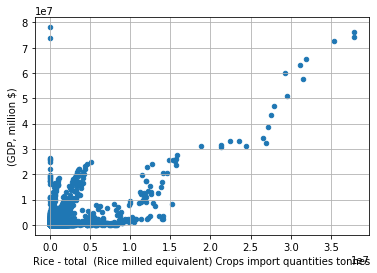

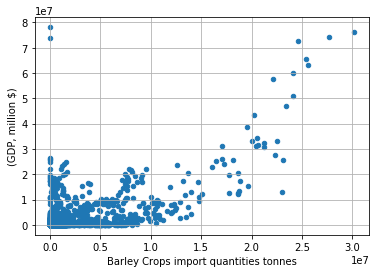

In [94]:
#Looking at some relationships
for item in list(top_traded_df.columns)[1:]:
    top_traded_df.plot(kind='scatter', x=item, y='(GDP, million $)', grid=True)


#### 3.Cc. Machine learning model <a name="3Cc"></a>

#### 1. Model - based on production

First, we only create a model using the production data. Afterwards, we use the data on exports, imports. 

#### Standardization, scaling


Clearly seeing that our data isn't normally distributed, this means we shouldn't use standardization. We'll use a min-max scaling to make different quantities comparable in the same model. 

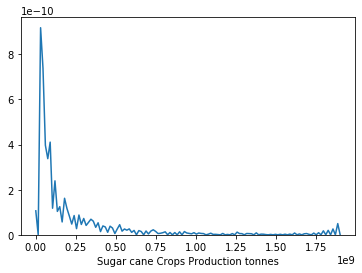

In [109]:
sns.distplot(maincrops_df["Sugar cane Crops Production tonnes"], rug=False, hist=False)

C:\Users\nanil\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


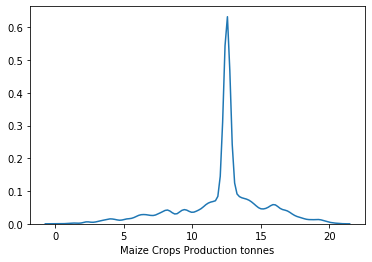

In [85]:
sns.distplot(np.log(maincrops_df["Maize Crops Production tonnes"]), rug=False, hist=False)

We can clearly see that the production is not normally distributed, thus we shouldn't use a normalization of our features.
The huge peak is probably from all the Nan values we set to the median...

In [117]:
#With MINMAX and not standardization, because it isn't a normal distribution.
top_production_values = top_production_df.values
min_max_scaler = preprocessing.MinMaxScaler()
top_production_minmaxed_values = min_max_scaler.fit_transform(top_production_values)
top_production_minmaxed = pd.DataFrame(top_production_minmaxed_values, columns=top_production_df.columns)
top_production_minmaxed.head(5)

(GDP, million $)  Cereals (Rice Milled Eqv) Crops Production tonnes  \
0          0.000022                                           0.001318   
1          0.000023                                           0.001245   
2          0.000020                                           0.001484   
3          0.000022                                           0.001606   
4          0.000028                                           0.001638   

   Sugar cane Crops Production tonnes  \
0                            0.000029   
1                            0.000026   
2                            0.000018   
3                            0.000030   
4                            0.000027   

   Roots and Tubers,Total Crops Production tonnes  \
0                                        0.000170   
1                                        0.000198   
2                                        0.000187   
3                                        0.000195   
4                                        0.000215   

   Vegetables&Melons, Total Crops Production tonnes  \
0                                          0.000412   
1                                          0.000477   
2                                          0.000428   
3                                          0.000440   
4                                          0.000443   

   Wheat Crops Production tonnes  Rice, paddy Crops Production tonnes  \
0                       0.002855                             0.000494   
1                       0.002627                             0.000472   
2                       0.003361                             0.000539   
3                       0.003704                             0.000566   
4                       0.003772                             0.000566   

   Maize Crops Production tonnes  \
0                       0.000643   
1                       0.000646   
2                       0.000694   
3                       0.000732   
4                       0.000742   

   Fruit excl Melons,Total Crops Production tonnes  \
0                                         0.001153   
1                                         0.000921   
2                                         0.001133   
3                                         0.001193   
4                                         0.001229   

   Sugar beet Crops Production tonnes  ...  Asses Livestock production Head  \
0                            0.000197  ...                         0.029312   
1                            0.000191  ...                         0.029312   
2                            0.000201  ...                         0.029312   
3                            0.000181  ...                         0.028185   
4                            0.000212  ...                         0.028185   

   Camels Livestock production Head  \
0                          0.010816   
1                          0.010816   
2                          0.010816   
3                          0.010816   
4                          0.010816   

   Animals live nes Livestock production Head  \
0                                    0.076211   
1                                    0.076211   
2                                    0.076211   
3                                    0.076211   
4                                    0.076211   

   Mules Livestock production Head  \
0                         0.002322   
1                         0.002322   
2                         0.002057   
3                         0.001758   
4                         0.001758   

   Poultry Birds Livestock production 1000 Head  \
0                                      0.000257   
1                                      0.000257   
2                                      0.000257   
3                                      0.000261   
4                                      0.000261   

   Chickens Livestock production 1000 Head  \
0                                 0.000280   
1                                 0.000280   
2

In [118]:
train_set, test_set = train_test_split(top_production_minmaxed.values, test_size = 0.2, random_state = 1)

X_train_set = train_set[:,1:]
Y_train_set = train_set[:,0]

X_test_set = test_set[:,1:]
Y_test_set = test_set[:,0]

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.91it/s]


The best value obtained is for alpha equal to 0.0 with a MSE of 0.0001899397214843352


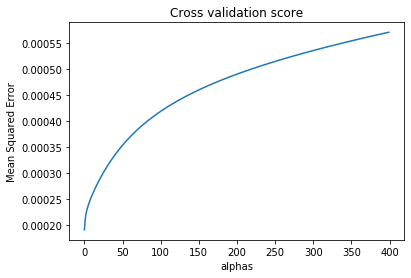

In [119]:
number_of_folds = 5
scores = []
list_of_alpha = [i for i in np.arange(0,400,1)]
for alpha in tqdm(list_of_alpha):
    clf = Ridge(alpha = alpha)
    score = cross_val_score(clf, X_train_set, Y_train_set, cv=number_of_folds, scoring = 'neg_mean_squared_error')
    scores.append([alpha, score.mean()])
a=np.array(scores)
print("The best value obtained is for alpha equal to " + str(a[np.where(a==np.amax(a[:,1]))[0]][0,0]) + " with a MSE of "+ str(-a[np.where(a==np.amax(a[:,1]))[0]][0,1]))
alphas = [elt[0] for elt in scores]
MSE = [-elt[1] for elt in scores]
sns.lineplot(alphas, MSE)
_ = plt.title("Cross validation score")
_ = plt.ylabel("Mean Squared Error")
_ = plt.xlabel("alphas")

In [124]:
#this means I choose my alpha as 0??
# We build our model with the chosen alpha.
model_top_production = Ridge(alpha=0)
model_top_production.fit(X_train_set, Y_train_set)



Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [126]:
weights_top_production = pd.DataFrame([model_top_production.coef_], columns=top_production_df.columns[1:])
weights_top_production = weights_top_production.sort_values(by=0, axis=1, ascending=False)                                  
weights_top_production

Chickens Livestock production 1000 Head  \
0                                 6.968226   

   Cereals (Rice Milled Eqv) Crops Production tonnes  \
0                                           1.049415   

   Fruit excl Melons,Total Crops Production tonnes  \
0                                         0.778406   

   Cattle Livestock production Head  \
0                          0.530833   

   Roots and Tubers,Total Crops Production tonnes  \
0                                        0.380118   

   Ducks Livestock production 1000 Head  Sugar beet Crops Production tonnes  \
0                              0.236095                            0.221196   

   Vegetables&Melons, Total Crops Production tonnes  \
0                                          0.198248   

   Buffaloes Livestock production Head  \
0                             0.150289   

   Sheep and Goats Livestock production Head  ...  \
0                                   0.119379  ...   

   Grapes Crops Production tonnes  Barley Crops Production tonnes  \
0                       -0.127099                       -0.133032   

   Citrus Fruit,Total Crops Production tonnes  \
0                                   -0.137365   

   Bananas Crops Production tonnes  Cassava Crops Production tonnes  \
0                        -0.168986                        -0.171376   

   Sorghum Crops Production tonnes  Rice, paddy Crops Production tonnes  \
0                        -0.270677                            -0.348605   

   Potatoes Crops Production tonnes  \
0                          -0.55206   

   Cattle and Buffaloes Livestock production Head  \
0                                       -0.786411   

   Poultry Birds Livestock production 1000 Head  
0                                     -7.247204  

[1 rows x 40 columns]

In [127]:
model_maincrops.score(X_train_set, Y_train_set)

0.8402735698901358

The result doesn't seem to make sense!! probably because chickens and poultry are so highly correlated. 

#### 2. Model - based on trade

In [131]:
#With MINMAX and not standardization, because it isn't a normal distribution.
top_traded_values = top_traded_df.values
min_max_scaler = preprocessing.MinMaxScaler()
top_traded_minmaxed_values = min_max_scaler.fit_transform(top_traded_values)
top_traded_minmaxed = pd.DataFrame(top_traded_minmaxed_values, columns=top_traded_df.columns)
top_traded_minmaxed.head(5)

(GDP, million $)  Cereals Crops export quantities tonnes  \
0          0.000022                                0.000052   
1          0.000023                                0.000052   
2          0.000020                                0.000052   
3          0.000022                                0.000052   
4          0.000028                                0.000052   

   Wheat+Flour,Wheat Equivalent Crops export quantities tonnes  \
0                                           0.000014             
1                                           0.000014             
2                                           0.000014             
3                                           0.000014             
4                                           0.000014             

   Wheat Crops export quantities tonnes  \
0                              0.000004   
1                              0.000004   
2                              0.000004   
3                              0.000004   
4                              0.000004   

   Fodder & Feeding stuff Crops export quantities tonnes  \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                                0.0       

   Maize Crops export quantities tonnes  \
0                              0.000007   
1                              0.000007   
2                              0.000007   
3                              0.000007   
4                              0.000007   

   Milk Equivalent Crops export quantities tonnes  \
0                                        0.000031   
1                                        0.000031   
2                                        0.000031   
3                                        0.000031   
4                                        0.000031   

   Sugar and Honey Crops export quantities tonnes  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   

   Oilseeds Crops export quantities tonnes  \
0                                 0.000050   
1                                 0.000024   
2                                 0.000241   
3                                 0.000193   
4                                 0.000129   

   Oilseed Cake Meal Crops export quantities tonnes  ...  \
0                                               0.0  ...   
1                                               0.0  ...   
2                                               0.0  ...   
3                                               0.0  ...   
4                                               0.0  ...   

   Cake, soybeans Crops import quantities tonnes  \
0                                        0.00031   
1                                        0.00031   
2                                        0.00031   
3                                        0.00031   
4                                        0.00031   

   Animal Vegetable Oil Crops import quantities tonnes  \
0                                           0.000090     
1                                           0.000127     
2                                           0.000157     
3                                           0.000111     
4                                           0.000119     

   Sugar,Total (Raw Equiv.) Crops import quantities tonnes  \
0                                           0.000954         
1                                           0.000818         
2                                           0.000767         
3                                           0.001009         
4                                           0.000894         

   Beverages Crops import quantities 

In [132]:
train_set, test_set = train_test_split(top_traded_minmaxed.values, test_size = 0.2, random_state = 1)

X_train_set = train_set[:,1:]
Y_train_set = train_set[:,0]

X_test_set = test_set[:,1:]
Y_test_set = test_set[:,0]

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:43<00:00,  9.29it/s]


The best value obtained is for alpha equal to 0.0 with a MSE of 0.00026671001602446656


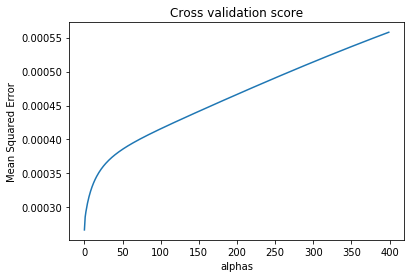

In [133]:
number_of_folds = 5
scores = []
list_of_alpha = [i for i in np.arange(0,400,1)]
for alpha in tqdm(list_of_alpha):
    clf = Ridge(alpha = alpha)
    score = cross_val_score(clf, X_train_set, Y_train_set, cv=number_of_folds, scoring = 'neg_mean_squared_error')
    scores.append([alpha, score.mean()])
a=np.array(scores)
print("The best value obtained is for alpha equal to " + str(a[np.where(a==np.amax(a[:,1]))[0]][0,0]) + " with a MSE of "+ str(-a[np.where(a==np.amax(a[:,1]))[0]][0,1]))
alphas = [elt[0] for elt in scores]
MSE = [-elt[1] for elt in scores]
sns.lineplot(alphas, MSE)
_ = plt.title("Cross validation score")
_ = plt.ylabel("Mean Squared Error")
_ = plt.xlabel("alphas")

In [135]:
# We build our model with the chosen alpha.
model_trade = Ridge(alpha=0)
model_trade.fit(X_train_set, Y_train_set)



Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [137]:
weights_trade = pd.DataFrame([model_trade.coef_], columns=top_traded_minmaxed.columns[1:])
weights_trade = weights_trade.sort_values(by=0, axis=1, ascending=False)                                  
weights_trade

Rice - total  (Rice milled equivalent) Crops export quantities tonnes  \
0                                            3.04501                       

   Fodder & Feeding stuff Crops import quantities tonnes  \
0                                           1.034067       

   Fodder & Feeding stuff Crops export quantities tonnes  \
0                                           0.776319       

   Rice - total  (Rice milled equivalent) Crops import quantities tonnes  \
0                                           0.537593                       

   Fixed Vegetable Oils Crops import quantities tonnes  \
0                                           0.433523     

   Maize Crops export quantities tonnes  \
0                              0.411777   

   Fixed Vegetable Oils Crops export quantities tonnes  \
0                                           0.399938     

   Soybeans Crops import quantities tonnes  \
0                                 0.396629   

   Wheat Crops export quantities tonnes  \
0                              0.382785   

   Total Meat Crops export quantities tonnes  ...  \
0                                    0.32971  ...   

   Wheat Crops import quantities tonnes  \
0                              -0.12249   

   Animal Vegetable Oil Crops import quantities tonnes  \
0                                          -0.142197     

   Milk Equivalent Crops export quantities tonnes  \
0                                       -0.149117   

   Oilseeds Crops import quantities tonnes  \
0                                -0.382451   

   Animal Vegetable Oil Crops export quantities tonnes  \
0                                            -0.3866     

   Oilseed Cake Meal Crops export quantities tonnes  \
0                                         -0.390715   

   Rice Crops import quantities tonnes  \
0                            -0.581538   

   Oilseed Cake Meal Crops import quantities tonnes  \
0                                          -1.10162   

   Cereals Crops export quantities tonnes  Rice Crops export quantities tonnes  
0                               -1.149509                             -2.92374  

[1 rows x 40 columns]

In [ ]:
model_trade.score(X_train_set, Y_train_set)

This needs to be cleaned, bc obviously the one with highest and lowest weights are actually super related.

### 4. Informed plan for next actions  <a name="4"></a>

Our results seem pretty intersting to share to the world. Moreover we have nice interactive maps and we would like to focus more on visual and style than writting on methodology. Therefore, we would like to produce a data story.
